### Hybrid Recommender System using Singular Value Decomposition and Support Vector Machine in Bali Tourism - Source Code Model Tugas Akhir (1301184175) I Komang Gede Aryadi Pramarta

### Import Library

In [1]:
## Using dill library to Running Session that Saved
import dill
dill.load_session('notebook_env.db')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import GridSearchCV
import nltk
import warnings
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

### Read Dataset

In [16]:
dt_destination = pd.read_csv('dataset_destination.csv')
dt_rating = pd.read_csv('dt_rating1.csv')
dt_user = pd.read_csv('dt_user.csv')

<AxesSubplot:xlabel='Rating', ylabel='count'>

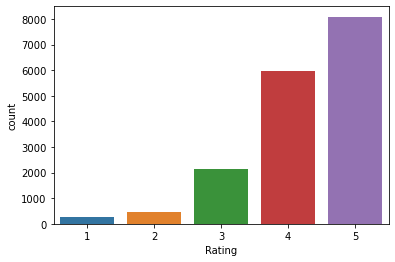

In [45]:
# Visualisasi Rating in Dataset Rating
sns.countplot(x='Rating',data=dt_rating)

## Create Model Collaborative Filtering using SVD

### Find Hyperparameter in SVD Model

In [9]:
reader = Reader()
data = Dataset.load_from_df(dt_rating[['user_id', 'destination_id', 'Rating']], reader)

In [10]:
param_grid = {'n_factors':[50,100,150],'n_epochs':[20,30],  'lr_all':[0.005,0.01],'reg_all':[0.02,0.1]}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(data)
print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

0.8452563609667086
{'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1}


In [11]:
algo = SVD(n_factors=50, n_epochs=20,lr_all=0.005,reg_all=0.1)

### Build Code for Model Collaborative Filtering Using SVD

In [13]:
### Set Rating Scale between 1 to 5
reader = Reader(rating_scale=(1, 5))

In [14]:
dt_destination.head()

destination_id          Destination Name  Rating  Total Review  \
0               1  Mandala Suci Wenara Wana       4        34.872   
1               2              Gunung Agung       4       455.000   
2               3             Waterbom Bali       4        15.502   
3               4         Pantai Double Six       4         2.031   
4               5           Pantai Seminyak       4         5.637   

                             Category  \
0  Area Wisata Alam& Taman Margasatwa   
1                          Pegunungan   
2                           Taman Air   
3                              Pantai   
4                              Pantai   

                                            Location         Duration   \
0            Jl. Monkey Forest, Ubud 80571 Indonesia           1-2 jam   
1  Besakih, Kecamatan Karangasem, Kabupaten Karan...  Lebih dari 3 jam   
2            Jl. Kartika Plaza, Kuta 80361 Indonesia  Lebih dari 3 jam   
3  Legian, Jl. Double Six, Seminyak, Kuta, Kabupa...           2-3 jam   
4    Desa Seminyak, Kecamatan Kuta, Kabupaten Badung           2-3 jam   

   Latitude   Longitude     Regency  \
0 -8.512077  115.261053     Gianyar   
1 -8.338936  115.508228  Karangasem   
2 -8.730345  115.167818      Badung   
3 -8.696862  115.161924      Badung   
4 -8.691655  115.157316      Badung   

                                         Description  
0  Mandala Suci Wenara Wana atau disebut juga Mon...  
1  Gunung Agung adalah gunung tertinggi di pulau ...  
2  Taman bermain air yang dilengkapi dengan wahan...  
3  Pantai di Seminyak ini punya banyak daya pikat...  
4  Pantai seminyak (beberapa orang menyebutnya Pa...

In [15]:
### Create Model for SVD using the hyperparameter
total_destination = 120
all_destination = dt_rating.destination_id.unique()
data_cf = Dataset.load_from_df(dt_rating[['user_id', 'destination_id', 'Rating']], reader)
trainset = data_cf.build_full_trainset()
model = SVD(n_factors=100, n_epochs=20,lr_all=0.005,reg_all=0.1)
model.fit(trainset)

In [10]:
### Create Function to easy running the Model Collaborative Filtering using SVD
def recommend_collaborative_svd(user_id):
    already_rated_dest = dt_rating[dt_rating.user_id == user_id].destination_id
    not_rated_dest = [destination_id for destination_id in all_destination if destination_id not in already_rated_dest]
    predict_rtscore = [model.predict(user_id, destination_id).est for destination_id in not_rated_dest]
    predict_result = pd.DataFrame({'destination_id': not_rated_dest, 'predict_cf_rate' : predict_rtscore})
    print('Rating Prediction for User :',user_id)
    predict_result_cb = pd.merge(predict_result, dt_destination, on='destination_id')
    predict_result_cb = predict_result_cb[['Destination Name','destination_id','predict_cf_rate']]
    return predict_result_cb

def collaborative_filtering(user_id,destination_id,dataset):
    reader = Reader(rating_scale=(1, 5))
    data_new = Dataset.load_from_df(dataset[['user_id', 'destination_id', 'Rating']], reader)
    train_set = data_new.build_full_trainset()
    model = SVD(n_factors=100, n_epochs=20,lr_all=0.005,reg_all=0.1)
    model.fit(train_set)
    rat_predict_cf = model.predict(user_id, destination_id).est
    return rat_predict_cf

## Create Model Content Based Filtering

### Build Item Profiles

In [4]:
dt_destination.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   destination_id    120 non-null    int64  
 1   Destination Name  120 non-null    object 
 2   Rating            120 non-null    int64  
 3   Total Review      120 non-null    float64
 4   Category          120 non-null    object 
 5   Location          120 non-null    object 
 6   Duration          120 non-null    object 
 7   Latitude          120 non-null    float64
 8   Longitude         120 non-null    float64
 9   Regency           120 non-null    object 
 10  Description       120 non-null    object 
dtypes: float64(3), int64(2), object(6)
memory usage: 10.4+ KB


In [5]:
dt_destination.head()

destination_id          Destination Name  Rating  Total Review  \
0               1  Mandala Suci Wenara Wana       4        34.872   
1               2              Gunung Agung       4       455.000   
2               3             Waterbom Bali       4        15.502   
3               4         Pantai Double Six       4         2.031   
4               5           Pantai Seminyak       4         5.637   

                             Category  \
0  Area Wisata Alam& Taman Margasatwa   
1                          Pegunungan   
2                           Taman Air   
3                              Pantai   
4                              Pantai   

                                            Location         Duration   \
0            Jl. Monkey Forest, Ubud 80571 Indonesia           1-2 jam   
1  Besakih, Kecamatan Karangasem, Kabupaten Karan...  Lebih dari 3 jam   
2            Jl. Kartika Plaza, Kuta 80361 Indonesia  Lebih dari 3 jam   
3  Legian, Jl. Double Six, Seminyak, Kuta, Kabupa...           2-3 jam   
4    Desa Seminyak, Kecamatan Kuta, Kabupaten Badung           2-3 jam   

   Latitude   Longitude     Regency  \
0 -8.512077  115.261053     Gianyar   
1 -8.338936  115.508228  Karangasem   
2 -8.730345  115.167818      Badung   
3 -8.696862  115.161924      Badung   
4 -8.691655  115.157316      Badung   

                                         Description  
0  Mandala Suci Wenara Wana atau disebut juga Mon...  
1  Gunung Agung adalah gunung tertinggi di pulau ...  
2  Taman bermain air yang dilengkapi dengan wahan...  
3  Pantai di Seminyak ini punya banyak daya pikat...  
4  Pantai seminyak (beberapa orang menyebutnya Pa...

In [6]:
dt_item_prof = dt_destination.copy()

### Text Preprocessing in Build Item Profile

In [7]:
### Doing Case Folding Text Preprocessing
import re
features_extract = ['Duration ','Description','Regency']
for column in features_extract:
    dt_item_prof[column] = dt_item_prof[column].apply(lambda x: x.lower())
    dt_item_prof[column] = dt_item_prof[column].apply(lambda x: re.sub('[^a-zA-Z 0-9]', ' ',x))

In [8]:
dt_item_prof = dt_item_prof[['destination_id','Destination Name','Duration ','Regency','Description']]

In [9]:
dt_item_prof

destination_id          Destination Name         Duration      Regency  \
0                 1  Mandala Suci Wenara Wana           1 2 jam     gianyar   
1                 2              Gunung Agung  lebih dari 3 jam  karangasem   
2                 3             Waterbom Bali  lebih dari 3 jam      badung   
3                 4         Pantai Double Six           2 3 jam      badung   
4                 5           Pantai Seminyak           2 3 jam      badung   
..              ...                       ...               ...         ...   
115             116         Oasis Yoga Studio           2 3 jam    seminyak   
116             117                Peek A Boo           1 2 jam    denpasar   
117             118                 Goa Gajah           1 2 jam     gianyar   
118             119            Pantai Prancak           2 3 jam      badung   
119             120        Pantai Nyang-nyang  lebih dari 3 jam      badung   

                                           Description  
0    mandala suci wenara wana atau disebut juga mon...  
1    gunung agung adalah gunung tertinggi di pulau ...  
2    taman bermain air yang dilengkapi dengan wahan...  
3    pantai di seminyak ini punya banyak daya pikat...  
4    pantai seminyak  beberapa orang menyebutnya pa...  
..                                                 ...  
115  kami memiliki lebih dari beberapa program di l...  
116  tempat yang sangat cocok untuk membawa anak be...  
117  gua gajah adalah gua buatan dari masa purbakal...  
118  pantai perancak di desa tibubeneng canggu  ber...  
119  pantai terpencil ini memiliki hamparan pasir y...  

[120 rows x 5 columns]

In [10]:
### Combine Feature to metadata_soup
dt_item_prof['metadata_soup'] = dt_item_prof['Regency'] + ' ' + dt_item_prof['Description'] + ' ' + dt_item_prof['Duration ']

In [11]:
dt_item_prof

destination_id          Destination Name         Duration      Regency  \
0                 1  Mandala Suci Wenara Wana           1 2 jam     gianyar   
1                 2              Gunung Agung  lebih dari 3 jam  karangasem   
2                 3             Waterbom Bali  lebih dari 3 jam      badung   
3                 4         Pantai Double Six           2 3 jam      badung   
4                 5           Pantai Seminyak           2 3 jam      badung   
..              ...                       ...               ...         ...   
115             116         Oasis Yoga Studio           2 3 jam    seminyak   
116             117                Peek A Boo           1 2 jam    denpasar   
117             118                 Goa Gajah           1 2 jam     gianyar   
118             119            Pantai Prancak           2 3 jam      badung   
119             120        Pantai Nyang-nyang  lebih dari 3 jam      badung   

                                           Description  \
0    mandala suci wenara wana atau disebut juga mon...   
1    gunung agung adalah gunung tertinggi di pulau ...   
2    taman bermain air yang dilengkapi dengan wahan...   
3    pantai di seminyak ini punya banyak daya pikat...   
4    pantai seminyak  beberapa orang menyebutnya pa...   
..                                                 ...   
115  kami memiliki lebih dari beberapa program di l...   
116  tempat yang sangat cocok untuk membawa anak be...   
117  gua gajah adalah gua buatan dari masa purbakal...   
118  pantai perancak di desa tibubeneng canggu  ber...   
119  pantai terpencil ini memiliki hamparan pasir y...   

                                         metadata_soup  
0    gianyar mandala suci wenara wana atau disebut ...  
1    karangasem gunung agung adalah gunung tertingg...  
2    badung taman bermain air yang dilengkapi denga...  
3    badung pantai di seminyak ini punya banyak day...  
4    badung pantai seminyak  beberapa orang menyebu...  
..                                                 ...  
115  seminyak kami memiliki lebih dari beberapa pro...  
116  denpasar tempat yang sangat cocok untuk membaw...  
117  gianyar gua gajah adalah gua buatan dari masa ...  
118  badung pantai perancak di desa tibubeneng cang...  
119  badung pantai terpencil ini memiliki hamparan ...  

[120 rows x 6 columns]

In [12]:
#Tokenizing
import string 
import re #regex library

# import word_tokenize & FreqDist from NLTK
from nltk.tokenize import word_tokenize 
from nltk.probability import FreqDist

def cleaning_text(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    #remove number
    text = re.sub(r"\d+", "", text)
    return text

#melakukan remove terhadap tanda baca
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

#melakukan remove single char
def remove_single_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

#nltk word tokenize
def word_tokenize_wrapper(text):
    return nltk.tokenize.word_tokenize(text)

In [21]:
from nltk.corpus import stopwords

def filtering_stopword(text):
    # get Indonesian stopword 
    list_stopwords = set(stopwords.words('indonesian'))
    #remove stopword pada list token
    tokens_without_stopword = [word for word in text if not word in list_stopwords]
    return tokens_without_stopword

def join_text(text):
    text = ' '.join(text)
    return text

In [13]:
dt_item_prof['metadata_soup'] = dt_item_prof['metadata_soup'].apply(cleaning_text)
dt_item_prof['metadata_soup'] = dt_item_prof['metadata_soup'].apply(remove_punctuation)
dt_item_prof['metadata_soup'] = dt_item_prof['metadata_soup'].apply(remove_single_char)
dt_item_prof['metadata_soup'] = dt_item_prof['metadata_soup'].apply(word_tokenize_wrapper)

In [19]:
dt_item_prof['metadata_soup'] = dt_item_prof['metadata_soup'].apply(filtering_stopword)

In [22]:
dt_item_prof['metadata_soup'] = dt_item_prof['metadata_soup'].apply(join_text)

In [23]:
dt_item_prof.head()

destination_id          Destination Name         Duration      Regency  \
0               1  Mandala Suci Wenara Wana           1 2 jam     gianyar   
1               2              Gunung Agung  lebih dari 3 jam  karangasem   
2               3             Waterbom Bali  lebih dari 3 jam      badung   
3               4         Pantai Double Six           2 3 jam      badung   
4               5           Pantai Seminyak           2 3 jam      badung   

                                         Description  \
0  mandala suci wenara wana atau disebut juga mon...   
1  gunung agung adalah gunung tertinggi di pulau ...   
2  taman bermain air yang dilengkapi dengan wahan...   
3  pantai di seminyak ini punya banyak daya pikat...   
4  pantai seminyak  beberapa orang menyebutnya pa...   

                                       metadata_soup  
0  gianyar mandala suci wenara wana monkey forest...  
1  karangasem gunung agung gunung tertinggi pulau...  
2  badung taman bermain air dilengkapi wahana umu...  
3  badung pantai seminyak daya pikat wisatawan me...  
4  badung pantai seminyak orang menyebutnya panta...

### TF-IDF Vectors

In [24]:
from sklearn.metrics.pairwise import cosine_similarity
tf_idf = TfidfVectorizer()
dt_destination_tf_idf_described = tf_idf.fit_transform(dt_item_prof.metadata_soup)

In [25]:
dt_destination_tf_idf_described

<120x1155 sparse matrix of type '<class 'numpy.float64'>'
	with 2575 stored elements in Compressed Sparse Row format>

In [26]:
df_tfidf_d2d = pd.DataFrame(cosine_similarity(dt_destination_tf_idf_described))
index_to_destination_id = dt_item_prof['destination_id']
df_tfidf_d2d.columns = [str(index_to_destination_id[int(col)]) for col in df_tfidf_d2d.columns]
df_tfidf_d2d.index = [index_to_destination_id[idx] for idx in df_tfidf_d2d.index]

In [27]:
#matrix cosine similarity antara destination
df_tfidf_d2d

1         2         3         4         5         6         7  \
1    1.000000  0.034841  0.003199  0.001840  0.030608  0.004051  0.017567   
2    0.034841  1.000000  0.002894  0.001665  0.055172  0.008695  0.047734   
3    0.003199  0.002894  1.000000  0.010488  0.021431  0.108441  0.011816   
4    0.001840  0.001665  0.010488  1.000000  0.246054  0.001102  0.168448   
5    0.030608  0.055172  0.021431  0.246054  1.000000  0.012684  0.076690   
..        ...       ...       ...       ...       ...       ...       ...   
116  0.001540  0.001394  0.002320  0.033907  0.112400  0.029368  0.038200   
117  0.002593  0.002346  0.066495  0.002246  0.002645  0.038462  0.002531   
118  0.073685  0.068310  0.003276  0.001885  0.068130  0.012292  0.017994   
119  0.057658  0.002634  0.016593  0.085529  0.162060  0.001743  0.010756   
120  0.003481  0.003150  0.019838  0.102257  0.236006  0.020379  0.012860   

            8         9        10  ...       111       112       113  \
1    0.039847  0.038769  0.001608  ...  0.029027  0.003273  0.002974   
2    0.014439  0.046384  0.011753  ...  0.078138  0.002962  0.002691   
3    0.003180  0.011368  0.009165  ...  0.119840  0.083954  0.004479   
4    0.001830  0.140950  0.081515  ...  0.011235  0.002836  0.002577   
5    0.077826  0.209856  0.187886  ...  0.041433  0.003339  0.072557   
..        ...       ...       ...  ...       ...       ...       ...   
116  0.001532  0.001447  0.011403  ...  0.002485  0.072741  0.002157   
117  0.018690  0.002435  0.001963  ...  0.004182  0.340701  0.089949   
118  0.054337  0.017312  0.001647  ...  0.029733  0.024308  0.022088   
119  0.048294  0.197179  0.146173  ...  0.168368  0.004487  0.004077   
120  0.003461  0.179501  0.112495  ...  0.021250  0.005365  0.004875   

          114       115       116       117       118       119       120  
1    0.003541  0.003260  0.001540  0.002593  0.073685  0.057658  0.003481  
2    0.027451  0.002950  0.001394  0.002346  0.068310  0.002634  0.003150  
3    0.005331  0.004910  0.002320  0.066495  0.003276  0.016593  0.019838  
4    0.095461  0.111315  0.033907  0.002246  0.001885  0.085529  0.102257  
5    0.148637  0.070099  0.112400  0.002645  0.068130  0.162060  0.236006  
..        ...       ...       ...       ...       ...       ...       ...  
116  0.002568  0.002364  1.000000  0.169084  0.001578  0.002112  0.024682  
117  0.004322  0.028851  0.169084  1.000000  0.019253  0.003554  0.004249  
118  0.003627  0.024212  0.001578  0.019253  1.000000  0.026366  0.003566  
119  0.102301  0.049337  0.002112  0.003554  0.026366  1.000000  0.113871  
120  0.250335  0.058986  0.024682  0.004249  0.003566  0.113871  1.000000  

[120 rows x 120 columns]

### Build User Profile

In [34]:
#example using user_id 2
dt_rating_user = dt_rating[dt_rating.user_id == 2]

In [35]:
dt_rating_user

Rating                                             Review  \
15434       5  Yang terbaik adalah untuk menyewa sepeda motor...   

       destination_id  user_id  
15434              94        2

In [36]:
dt_user_data = dt_item_prof.reset_index().merge(dt_rating_user, on='destination_id')

In [37]:
dt_user_data

index  destination_id Destination Name         Duration  Regency  \
0     93              94      Danau Batur  lebih dari 3 jam  bangli   

                                         Description  \
0  danau batur adalah danau kawah di kintamani  k...   

                                       metadata_soup  Rating  \
0  bangli danau batur adalah danau kawah di kinta...       5   

                                              Review  user_id  
0  Yang terbaik adalah untuk menyewa sepeda motor...        2

In [38]:
#perhitungan pembobotan rating dengan melakukan pembagian dengan rating tertinggi yang ada pada dataset
dt_user_data['weight'] = dt_user_data['Rating']/5.

In [39]:
#hitung user profile 
user_profile = np.dot(dt_destination_tf_idf_described[dt_user_data['index'].values].toarray().T, dt_user_data['weight'].values)

In [40]:
print(user_profile)

[0. 0. 0. ... 0. 0. 0.]


In [41]:
C = cosine_similarity(np.atleast_2d(user_profile), dt_destination_tf_idf_described)

In [42]:
C[0][0]

0.09583553643663893

In [43]:
sim_data = []
for i in range(120):
    sim_data.append(C[0][i])
len(sim_data)
df = pd.DataFrame(columns=['destination_id','cosine_similarity'])
df['destination_id'] = pd.Series(range(1,121))
df['cosine_similarity'] = sim_data
df

destination_id  cosine_similarity
0                 1           0.095836
1                 2           0.279301
2                 3           0.018136
3                 4           0.032691
4                 5           0.041169
..              ...                ...
115             116           0.034350
116             117           0.001812
117             118           0.092070
118             119           0.040561
119             120           0.020664

[120 rows x 2 columns]

#### Rating Calculation Content Based using Formula

In [28]:
def rating_prediction_cb(df,destination_id,threshold,x):
    cosine_sim = df[df.destination_id == destination_id]
    rating = (x-threshold) * cosine_sim.iloc[0]['cosine_similarity'] + threshold
    return rating

#### Create Function to Easy Running Content Based Recommender

In [29]:
def content_based_recommender(userid,destination_id,dataset):
    x = 5
    threshold = 4
    destination = []
    dt_rating_user = dataset[dataset.user_id == userid]
    dt_user_data = dt_item_prof.reset_index().merge(dt_rating_user, on='destination_id')
    dt_user_data['weight'] = dt_user_data['Rating']/5.
    user_profile = np.dot(dt_destination_tf_idf_described[dt_user_data['index'].values].toarray().T, dt_user_data['weight'].values)
    C = cosine_similarity(np.atleast_2d(user_profile), dt_destination_tf_idf_described)
    sim_data = []
    for i in range(120):
        sim_data.append(C[0][i])
    df = pd.DataFrame(columns=['destination_id','cosine_similarity'])
    df['destination_id'] = pd.Series(range(1,121))
    df['cosine_similarity'] = sim_data
    return rating_prediction_cb(df,destination_id,threshold,x)

In [30]:
### Example Running for Function Content Based Recommender
content_based_recommender(1,1,dt_fold_training10)

4.037440322848922

## Create Model Demographic Filtering using Support Vector Machine

In [64]:
### show data rating
dt_rating

Rating                                             Review  \
8395        5  Kebersihan yang sangat dijaga dan kesehatan ya...   
5602        5  Indah, dan jauh dari keramaian! Permata sejati...   
5104        5  Sulit untuk mendapatkan untuk, tetapi ketika a...   
13260       1  Saya benar-benar ngeri melihat hewan-hewan kec...   
9791        4                                             #NAME?   
...       ...                                                ...   
16049       5  Banyak untuk melihat dan menavigasi melalui ba...   
8763        4  Seminyak Square merupakan pusat belanja relati...   
7656        5  Bibir pantai luas dengan ombak yang ramah dan ...   
10482       5  terletak di sebelah Pantai Uluwatu, pantai ini...   
16850       5  Tempat yang indah! Meskipun di dalam gua sanga...   

       destination_id  user_id  
8395               41     3031  
5602               21     3109  
5104               18     1913  
13260              75     1048  
9791               50     2261  
...               ...      ...  
16049             104      560  
8763               43      929  
7656               34      611  
10482              56      415  
16850             118      395  

[16951 rows x 4 columns]

In [65]:
### show data user_id
dt_user

user_id Travel_Style    Region     Country Member_Since
0           1     Keluarga   Jakarta   Indonesia     Apr 2021
1           2       Bisnis  Denpasar   Indonesia     Jan 2021
2           3       Bisnis      Ubud   Indonesia     Nov 2020
3           4     Keluarga   Jakarta   Indonesia     Mei 2016
4           5     Keluarga  Cikarang   Indonesia     Okt 2015
...       ...          ...       ...         ...          ...
3495     3496        Teman   Bintulu    Malaysia     Jan 2014
3496     3497        Teman   Bandung   Indonesia     Nov 2015
3497     3498        Teman   Jakarta   Indonesia     Nov 2015
3498     3499     Pasangan   Jakarta   Indonesia     Sep 2015
3499     3500     Keluarga  Surabaya   Indonesia     Sep 2015

[3500 rows x 5 columns]

In [66]:
# total unique country in data user
dt_user.Country.nunique()

194

In [67]:
# total unique Region in data user
dt_user.Region.nunique()

1065

In [68]:
# total unique Travel Style in data user
dt_user.Travel_Style.nunique()

5

#### Testing build Model Demographic Filtering usingSVM 

In [81]:
### Merge Dataset User and Rating
dt_combine = pd.merge(dt_fold_training1, dt_user, on='user_id',how='left')

In [69]:
dt_combine = pd.merge(dt_rating, dt_user, on='user_id')

In [70]:
dt_combine = dt_combine.sort_values(by='destination_id')
dt_combine = dt_combine.reset_index(drop=True)

In [71]:
dt_combine

Rating                                             Review  \
0           4  Bersuasana adem dan asri, tempat yg merupakan ...   
1           5  Saya suka monyet secara umum sehingga peringka...   
2           4  Wajib mampir jika ke Ubud, lokasi mudah dicari...   
3           4  Yang ingin melihat kehidupan monyet2, silakan ...   
4           4  Sudah beberapa kali saya mengunjungi tempat in...   
...       ...                                                ...   
16946       5  Pantainya sangat bagus dan luas namun untuk me...   
16947       3  untuk mencapai pantai ini kalian harus menurun...   
16948       5  Pantai nya sangat worthed banget untuk didatan...   
16949       4  Pantai Nyang Nyang berada di balik bukit, memi...   
16950       3  Jika anda bosan dengan suasana Kuta yang hinga...   

       destination_id  user_id Travel_Style            Region         Country  \
0                   1      891     Pasangan           Jakarta       Indonesia   
1                   1     1863     Keluarga  Kota Ho Chi Minh         Vietnam   
2                   1     1106       Bisnis          Jimbaran       Indonesia   
3                   1     2968       Bisnis             Medan       Indonesia   
4                   1     1825        Teman   Auckland Tengah   Selandia Baru   
...               ...      ...          ...               ...             ...   
16946             120     2561     Pasangan            London    Inggris Raya   
16947             120     1064        Teman          Surabaya       Indonesia   
16948             120     2060        Teman         Melbourne       Australia   
16949             120     1226     Pasangan         Hong Kong            Cina   
16950             120     1175     Keluarga         Pontianak       Indonesia   

      Member_Since  
0         Agu 2015  
1         Mei 2016  
2         Agu 2016  
3         Nov 2019  
4         Feb 2016  
...            ...  
16946     Jul 2014  
16947     Agu 2018  
16948     Sep 2012  
16949     Jun 2012  
16950     Okt 2012  

[16951 rows x 8 columns]

In [72]:
### Pick just important Feature
dt_combine = dt_combine[['destination_id','user_id','Travel_Style','Region','Country','Rating']]

In [74]:
list_destination_id = dt_combine.destination_id.unique()

In [6]:
### Create Function to split based on destination id 
def split_by_destination_id(destination_id,dataset):
    df = dataset[dataset.destination_id == destination_id]
    return df

In [78]:
dataframe['Region'] = dataframe['Region'].apply(lambda x: x.lower())
dataframe['Country'] = dataframe['Country'].apply(lambda x: x.lower())

In [79]:
dt_user_testing = dt_user[dt_user.user_id == 1]
dt_user_testing

user_id Travel_Style   Region     Country Member_Since
0        1     Keluarga  Jakarta   Indonesia     Apr 2021

In [80]:
data_combine_df = dataframe.append(dt_user_testing)
data_combine_df.head()

destination_id  user_id Travel_Style        Region        Country  \
1439             7.0      426     Keluarga      adelaide      australia   
1440             7.0     2328     Pasangan     singapura      singapura   
1441             7.0      148     Keluarga    balikpapan      indonesia   
1442             7.0     1314     Pasangan         derby   inggris raya   
1443             7.0      903        Teman  canning vale      australia   

      Rating Member_Since  
1439     4.0          NaN  
1440     5.0          NaN  
1441     3.0          NaN  
1442     5.0          NaN  
1443     4.0          NaN

In [86]:
import category_encoders as ce
one_hot_encoding =ce.OneHotEncoder(cols=['Travel_Style','Region','Country'],handle_unknown='return_nan',return_df=True,use_cat_names=True)

In [ ]:
data_encoded = one_hot_encoding.fit_transform(data_combine_df)
data_encoded.head()

In [ ]:
dt_predict_user = data_encoded.iloc[-1:]
data_encoded = data_encoded.head(-1)
y = data_encoded['Rating']
X = data_encoded.drop(['destination_id','user_id','Rating','Member_Since'], axis=1)
x_test = dt_predict_user.drop(['destination_id','user_id','Rating','Member_Since'],axis=1)

In [ ]:
x_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
grid_predictions = grid.predict(X_test)
print(grid_predictions)

In [ ]:
rat_pred = grid.predict(x_test)
print(rat_pred)

### Create Function to Running Model Demographic Filtering with Support Vector Machine

In [7]:
def demographic_filtering_using_svm(user_id,destination_id,dataset):
    dt_combine = pd.merge(dataset, dt_user, on='user_id',how='left')
    dt_combine = dt_combine[['destination_id','user_id','Travel_Style','Region','Country','Rating']]
    dataframe = split_by_destination_id(destination_id,dt_combine)
    dataframe['Region'] = dataframe['Region'].apply(lambda x: x.lower())
    dataframe['Country'] = dataframe['Country'].apply(lambda x: x.lower())
    dt_user_testing = dt_user[dt_user.user_id == user_id]
    data_combine_df = dataframe.append(dt_user_testing)
    data_encoded = one_hot_encoding.fit_transform(data_combine_df)
    dt_predict_user = data_encoded.iloc[-1:]
    data_encoded = data_encoded.head(-1)
    y = data_encoded['Rating']
    X = data_encoded.drop(['destination_id','user_id','Rating','Member_Since'], axis=1)
    x_test = dt_predict_user.drop(['destination_id','user_id','Rating','Member_Since'],axis=1)
    param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
    grid = GridSearchCV(SVC(decision_function_shape='ovo'),param_grid,refit=True,n_jobs=-1)
    grid.fit(X,y)
    print(grid.best_estimator_)
    rating_pred_demographic = grid.predict(x_test)
    return int(rating_pred_demographic)

In [13]:
### Testing Running the model demographic filtering with SVM
demographic_filtering_using_svm(1,1,dt_fold_training5)

SVC(C=10, decision_function_shape='ovo', gamma=0.01)


5

## Create Model Hybrid Recommender System Double Hybridization

### Function Weighted Method

In [3]:
def hybrid_weighted(user_id,destination_id,dataset,alpha,beta,gamma): 
    pred_cf = collaborative_filtering(user_id,destination_id,dataset)
    pred_cb = content_based_recommender(user_id,destination_id,dataset)
    pred_df = demographic_filtering_using_svm(user_id,destination_id,dataset)
    rating_weighted = (alpha*pred_df) + (beta*pred_cb) + (gamma*pred_cf)
    return rating_weighted

### Function to Finding Best Alpha,Beta and Gama

In [4]:
### Function to Calculate Value using Linear Programming
def linear_programming_problem(dt_training,dt_test,alpha,beta,gama):
    n = len(dt_test)
    hasil = 0
    for index,row in dt_test.iterrows():
        user_id = row['user_id']
        destination_id = row['destination_id']
        rating = np.abs(hybrid_weighted(user_id,destination_id,dt_training,alpha,beta,gama) - row['Rating'])
        hasil = hasil + rating
    return hasil/n

In [4]:
### Function to Calculate Value RMSE
def linear_programming_problem_rmse(dt_training,dt_test,alpha,beta,gama):
    n = len(dt_test)
    hasil = 0
    for index,row in dt_test.iterrows():
        user_id = row['user_id']
        destination_id = row['destination_id']
        rating = (hybrid_weighted(user_id,destination_id,dt_training,alpha,beta,gama) - row['Rating'])**2
        hasil = hasil + rating
    return np.sqrt(hasil/n)

### Function to find Optimal Coeff

In [5]:
def find_optimal_coeff(dt_fold_training,dt_fold_testing,alpha = True,beta = True,gamma = True):
    hasil_minimize_linear = []
    coeff_val = [0.2,0.4,0.6,0.8]
    if (alpha == True):
        for val in coeff_val:
            beta = np.round(((1 - val)/2),2)
            gamma = beta
            hasil_minimize_linear.append(linear_programming_problem(dt_fold_training,dt_fold_testing,val,beta,gamma))
    elif(beta == True):
        for val in coeff_val:
            alpha = np.round(((1 - val)/2),2)
            gamma = alpha
            hasil_minimize_linear.append(linear_programming_problem(dt_fold_training,dt_fold_testing,alpha,val,gamma))
    elif(gamma == True):
        for val in coeff_val:
            beta = np.round(((1 - val)/2),2)
            alpha = beta
            hasil_minimize_linear.append(linear_programming_problem(dt_fold_training,dt_fold_testing,alpha,beta,val))
    return hasil_minimize_linear

In [3]:
def find_optimal_coeff_rmse(dt_fold_training,dt_fold_testing,alpha = True,beta = True,gamma = True):
    hasil_minimize_linear = []
    coeff_val = [0.2,0.4,0.6,0.8]
    if (alpha == True):
        for val in coeff_val:
            beta = np.round(((1 - val)/2),2)
            gamma = beta
            hasil_minimize_linear.append(linear_programming_problem_rmse(dt_fold_training,dt_fold_testing,val,beta,gamma))
    elif(beta == True):
        for val in coeff_val:
            alpha = np.round(((1 - val)/2),2)
            gamma = alpha
            hasil_minimize_linear.append(linear_programming_problem_rmse(dt_fold_training,dt_fold_testing,alpha,val,gamma))
    elif(gamma == True):
        for val in coeff_val:
            beta = np.round(((1 - val)/2),2)
            alpha = beta
            hasil_minimize_linear.append(linear_programming_problem_rmse(dt_fold_training,dt_fold_testing,alpha,beta,val))
    return hasil_minimize_linear

In [61]:
dt_alpha_rmse = find_optimal_coeff_rmse(dt_fold_training1,dt_fold_testing1,True,False,False)

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_fu

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, d

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', g

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', ga

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, 

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, 

SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, 

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmo

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, dec

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SV

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_functi

SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=

SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_functio

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_fun

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, de

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo',

SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid'

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo'

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, 

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_func

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_fu

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmo

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_func

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_s

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kern

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape

SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, 

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_functi

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, dec

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ov

SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_func

In [62]:
dt_alpha_rmse

[0.7418980937729286,
 0.7578077575545559,
 0.8093816506297664,
 0.8969524603357906]

In [5]:
dt_alpha_rmse_fix1 = find_optimal_coeff_rmse(dt_fold_training1,dt_fold_testing1,True,False,False)

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_fu

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, d

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', g

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', ga

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, 

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, 

SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, 

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmo

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, dec

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SV

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_functi

SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=

SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_functio

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_fun

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, de

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo',

SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid'

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo'

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, 

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_func

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_fu

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmo

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_func

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_s

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kern

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape

SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, 

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_functi

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, dec

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ov

SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_func

In [6]:
print(dt_alpha_rmse_fix1)

[0.861440743033181, 0.8705098236668204, 0.8998084086360193, 0.9471262456161491]


In [5]:
dt_alpha_rmse_fix2 = find_optimal_coeff_rmse(dt_fold_training1,dt_fold_testing1,False,True,False)

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_fu

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, d

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', g

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', ga

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, 

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, 

SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, 

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmo

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, dec

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SV

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_functi

SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=

SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_functio

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_fun

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, de

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo',

SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid'

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo'

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, 

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_func

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_fu

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmo

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_func

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_s

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kern

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape

SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, 

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_functi

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, dec

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ov

SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_func

In [6]:
print(dt_alpha_rmse_fix2)

[0.8715118965950355, 0.865200783785519, 0.8715530499563402, 0.8915313403650658]


In [3]:
begin_time = datetime.datetime.now()
dt_gamma_rmse_fix = find_optimal_coeff_rmse(dt_fold_training1,dt_fold_testing1,False,False,True)
print(datetime.datetime.now() - begin_time)

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_fu

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, d

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', g

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', ga

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, 

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, 

SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, 

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmo

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, dec

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SV

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_functi

SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=

SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_functio

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_fun

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, de

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo',

SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid'

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo'

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, 

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_func

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_fu

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmo

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_func

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_s

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kern

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape

SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, 

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_functi

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, dec

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ov

SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_func

In [4]:
print(dt_gamma_rmse_fix)

[0.8720243825537787, 0.8648652541364494, 0.8586837752127764, 0.856456433133361]


In [67]:
find_optimal_coeff(dt_fold_training1,dt_fold_testing1,True,False,False)

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_fu

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, d

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', g

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', ga

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, 

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, 

SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, 

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmo

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, dec

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SV

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_functi

SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=

SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_functio

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_fun

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, de

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo',

SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid'

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo'

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, 

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_func

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_fu

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmo

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_func

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_s

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kern

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape

SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, 

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_functi

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, dec

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ov

SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_func

[0.6861983482340481,
 0.6735233788828556,
 0.6624709131754724,
 0.6508254431333785]

In [6]:
dt_alpha = [0.6861983482340481,
 0.6735233788828556,
 0.6624709131754724,
 0.6508254431333785]

In [11]:
begin_time = datetime.datetime.now()
dt_beta = find_optimal_coeff(dt_fold_training1,dt_fold_testing1,False,True,False)
print(datetime.datetime.now() - begin_time)

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_fu

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, d

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', g

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', ga

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, 

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, 

SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, 

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmo

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, dec

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SV

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_functi

SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=

SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_functio

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_fun

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, de

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo',

SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid'

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo'

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, 

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_func

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_fu

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmo

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_func

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_s

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kern

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape

SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, 

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_functi

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, dec

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ov

SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_func

In [26]:
begin_time = datetime.datetime.now()
dt_gamma = find_optimal_coeff(dt_fold_training1,dt_fold_testing1,False,False,True)
print(datetime.datetime.now() - begin_time)

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_fu

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, d

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', g

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', ga

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, 

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, 

SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, 

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmo

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, dec

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SV

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_functi

SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=

SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_functio

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_fun

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, de

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo',

SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid'

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo'

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, 

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_func

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_fu

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmo

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_func

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_s

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kern

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape

SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, 

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_functi

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, dec

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ov

SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_func

In [16]:
print(dt_gamma)
print(dt_alpha)
print(dt_beta)
hasil_coeff = dt_alpha + dt_beta + dt_gamma
print(hasil_coeff)

[0.6788844796284325, 0.6781368867252983, 0.6770822070179973, 0.677691560688209]
[0.6861983482340481, 0.6735233788828556, 0.6624709131754724, 0.6508254431333785]
[0.6692227710899236, 0.681613670571853, 0.696693673745115, 0.71086468337715]
[0.6861983482340481, 0.6735233788828556, 0.6624709131754724, 0.6508254431333785, 0.6692227710899236, 0.681613670571853, 0.696693673745115, 0.71086468337715, 0.6788844796284325, 0.6781368867252983, 0.6770822070179973, 0.677691560688209]


In [6]:
hasil_coeff_rmse = dt_alpha_rmse_fix1 + dt_alpha_rmse_fix2 + dt_gamma_rmse_fix
print(hasil_coeff_rmse)

[0.861440743033181, 0.8705098236668204, 0.8998084086360193, 0.9471262456161491, 0.8715118965950355, 0.865200783785519, 0.8715530499563402, 0.8915313403650658, 0.8720243825537787, 0.8648652541364494, 0.8586837752127764, 0.856456433133361]


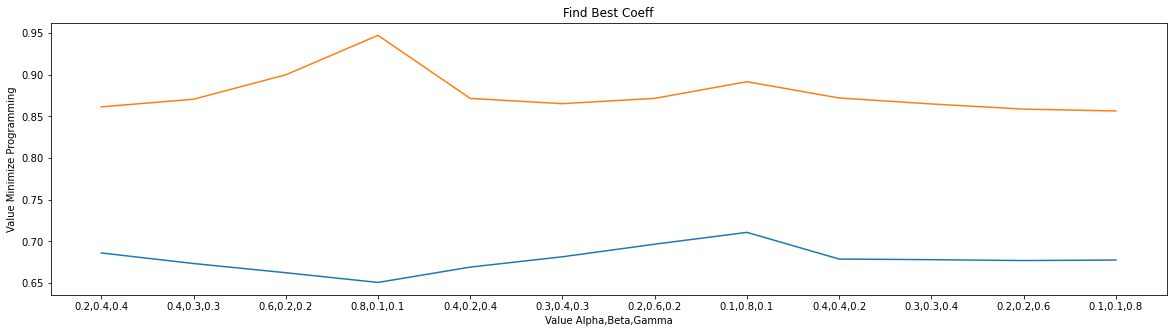

In [8]:
label_coeff = ['0.2,0.4,0.4','0.4,0.3,0.3','0.6,0.2,0.2','0.8,0.1,0.1','0.4,0.2,0.4','0.3,0.4,0.3','0.2,0.6,0.2','0.1,0.8,0.1'
              ,'0.4,0.4,0.2','0.3,0.3,0.4','0.2,0.2,0.6','0.1,0.1,0.8']
plt.plot(label_coeff, hasil_coeff)
plt.plot(label_coeff,hasil_coeff_rmse)
plt.title('Find Best Coeff')
plt.xlabel('Value Alpha,Beta,Gamma')
plt.ylabel('Value Minimize Programming')
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
## Testing Best 3 Value RMSE and MAE
begin_time = datetime.datetime.now()
testing_pred_best1 = weighted_method_testing(dt_fold_testing1,dt_fold_training1,0.8,0.1,0.1)
testing_pred_best2 = weighted_method_testing(dt_fold_testing1,dt_fold_training1,0.4,0.2,0.4)
testing_pred_best3 = weighted_method_testing(dt_fold_testing1,dt_fold_training1,0.6,0.2,0.2)
print(datetime.datetime.now() - begin_time)

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_fu

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, d

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', g

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', ga

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, 

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, 

SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, 

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmo

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, dec

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SV

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_functi

SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=

SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_functio

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_fun

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, de

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo',

SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid'

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo'

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, 

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_func

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_fu

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmo

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_func

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C

In [4]:
print(find_mae(testing_pred_best1,y_test1))
print(find_rmse(testing_pred_best1,y_test1))

0.6508913859591565
0.9483967938624641


In [5]:
print(find_mae(testing_pred_best2,y_test1))
print(find_rmse(testing_pred_best2,y_test1))

0.6698640473482769
0.8732066942635638


In [6]:
print(find_mae(testing_pred_best3,y_test1))
print(find_rmse(testing_pred_best3,y_test1))

0.6623052270882928
0.901749861378671


### Value Best Alpha = 0.4 ,Beta = 0.2 and Gama = 0.4

### Combine Switching with Weighted (Double Hybridization)

In [101]:
### Function testing hybrid double hybridization
def hybrid_combine(user_id,dataset):
    rating_pred_combine = []
    already_rated_dest = dataset[dataset.user_id == user_id].destination_id.tolist()
    print(already_rated_dest)
    total = len(already_rated_dest)
    all_dest_id = dt_destination.destination_id.unique()
    not_rated_dest = [destination_id for destination_id in all_dest_id if destination_id not in already_rated_dest]
    count_not_rated_dest = len(not_rated_dest)
    for i in not_rated_dest:
        count_rating_destination = dataset[dataset.destination_id == i].destination_id
        if (count_not_rated_dest == len(all_dest_id)):
            rating_pred_combine.append(demographic_filtering_using_svm(user_id,i,dataset))
            print('masuk demographic')
        elif(len(count_rating_destination) == 0):
            rating_pred_combine.append(content_based_recommender(user_id,i,dataset))
            print('masuk content based')
        else:
            rating_pred_combine.append(hybrid_weighted(user_id,i,dataset))
            print('masuk combine weighted')
        print(i)
    return rating_pred_combine

### Function Model to Running Predictions in Hybrid Recommender System with Double Hybridization

In [11]:
def hybrid_combine_pred(user_id,destination_id,dataset,alpha,beta,gamma):
    already_rated_dest = dataset[dataset.user_id == user_id].destination_id.tolist()
    cek_destination_id = dataset[dataset.destination_id == destination_id]
    total = len(already_rated_dest)
    total_dest = len(cek_destination_id)
    if(total == 0):
        rating_pred_user = demographic_filtering_using_svm(user_id,destination_id,dataset)
    elif(total_dest == 0):
        rating_pred_user = content_based_recommender(user_id,destination_id,dataset)
    else:
        rating_pred_user = hybrid_weighted(user_id,destination_id,dataset,alpha,beta,gamma)
    return rating_pred_user

In [12]:
### testing running
hybrid_combine_pred(1,1,dt_fold_training2,0.5,0.1,0.4)

SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')


4.643618235251111

### Create Function To Calculate RMSE dan MAE

In [13]:
def find_mae(y_predict,y_test):
    n = len(y_predict)
    mae = np.sum(np.abs([y_predict[i] - y_test[i] for i in range(len(y_predict))]))/n
    return mae

In [14]:
def find_rmse(y_predict,y_test):
    n = len(y_predict)
    rmse = np.sqrt(np.sum([ (y_predict[i] - y_test[i])**2 for i in range(len(y_predict)) ])/n)
    return rmse

### Split all dataset rating to 10 Fold

In [18]:
X = dt_rating[['user_id','destination_id']]
y = dt_rating['Rating']
X = X.values.tolist()
y = y.values.tolist()

In [19]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[ 1696  1697  1698 ... 16948 16949 16950] [   0    1    2 ... 1693 1694 1695]
[    0     1     2 ... 16948 16949 16950] [1696 1697 1698 ... 3388 3389 3390]
[    0     1     2 ... 16948 16949 16950] [3391 3392 3393 ... 5083 5084 5085]
[    0     1     2 ... 16948 16949 16950] [5086 5087 5088 ... 6778 6779 6780]
[    0     1     2 ... 16948 16949 16950] [6781 6782 6783 ... 8473 8474 8475]
[    0     1     2 ... 16948 16949 16950] [ 8476  8477  8478 ... 10168 10169 10170]
[    0     1     2 ... 16948 16949 16950] [10171 10172 10173 ... 11863 11864 11865]
[    0     1     2 ... 16948 16949 16950] [11866 11867 11868 ... 13558 13559 13560]
[    0     1     2 ... 16948 16949 16950] [13561 13562 13563 ... 15253 15254 15255]
[    0     1     2 ... 15253 15254 15255] [15256 15257 15258 ... 16948 16949 16950]


In [20]:
dt_fold_testing1 = dt_rating.iloc[0:1695]
dt_fold_testing2 = dt_rating.iloc[1695:3390]
dt_fold_testing3 = dt_rating.iloc[3390:5085]
dt_fold_testing4 = dt_rating.iloc[5085:6780]
dt_fold_testing5 = dt_rating.iloc[6780:8475]
dt_fold_testing6 = dt_rating.iloc[8475:10170]
dt_fold_testing7 = dt_rating.iloc[10170:11865]
dt_fold_testing8 = dt_rating.iloc[11865:13560]
dt_fold_testing9 = dt_rating.iloc[13560:15255]
dt_fold_testing10 = dt_rating.iloc[15255:]

In [21]:
dt_fold_training1 = dt_rating.iloc[1696:]
dt_fold_training2 = pd.concat([dt_rating.iloc[1:1696],dt_rating.iloc[3391:]])
dt_fold_training3 = pd.concat([dt_rating.iloc[1:3391],dt_rating.iloc[5086:]])
dt_fold_training4 = pd.concat([dt_rating.iloc[1:5086],dt_rating.iloc[6781:]])
dt_fold_training5 = pd.concat([dt_rating.iloc[1:6781],dt_rating.iloc[8476:]])
dt_fold_training6 = pd.concat([dt_rating.iloc[1:8476],dt_rating.iloc[10171:]])
dt_fold_training7 = pd.concat([dt_rating.iloc[1:10171],dt_rating.iloc[11866:]])
dt_fold_training8 = pd.concat([dt_rating.iloc[1:11866],dt_rating.iloc[13561:]])
dt_fold_training9 = pd.concat([dt_rating.iloc[1:13561],dt_rating.iloc[15256:]])
dt_fold_training10 = dt_rating.iloc[:15255]

In [4]:
def collaborative_testing(dt_testing,dt_training):
    rating_pred = []
    for index,row in dt_testing.iterrows():
        user_id = row['user_id']
        destination_id = row['destination_id']
        rating_pred.append(collaborative_filtering(user_id,destination_id,dt_training))
    return rating_pred

In [175]:
import datetime

### Testing Model Collaborative Filtering with Singular Value Decomposition with 10 Fold

In [5]:
begin_time = datetime.datetime.now()
print(1)
rating_pred_fold1 = collaborative_testing(dt_fold_testing1,dt_fold_training1)
print(2)
rating_pred_fold2 = collaborative_testing(dt_fold_testing2,dt_fold_training2)
print(3)
rating_pred_fold3 = collaborative_testing(dt_fold_testing3,dt_fold_training3)
print(4)
rating_pred_fold4 = collaborative_testing(dt_fold_testing4,dt_fold_training4)
print(5)
rating_pred_fold5 = collaborative_testing(dt_fold_testing5,dt_fold_training5)
print(6)
rating_pred_fold6 = collaborative_testing(dt_fold_testing6,dt_fold_training6)
print(7)
rating_pred_fold7 = collaborative_testing(dt_fold_testing7,dt_fold_training7)
print(8)
rating_pred_fold8 = collaborative_testing(dt_fold_testing8,dt_fold_training8)
print(9)
rating_pred_fold9 = collaborative_testing(dt_fold_testing9,dt_fold_training9)
print(10)
rating_pred_fold10 = collaborative_testing(dt_fold_testing10,dt_fold_training10)
print(datetime.datetime.now() - begin_time)

1
2
3
4
5
6
7
8
9
10
4:05:37.451681


### Calculate MAE and RMSE Model Collaborative Filtering with Singular Value Decomposition for Each Fold 

In [79]:
mae_cf = []
rmse_cf = []
y_test1 = dt_fold_testing1.Rating.to_list()
print('MAE and RMSE fold 1')
mae_cf_fold1 = find_mae(rating_pred_fold1,y_test1)
rmse_cf_fold1 = find_rmse(rating_pred_fold1,y_test1)
print(mae_cf_fold1)
print(rmse_cf_fold1)
mae_cf.append(mae_cf_fold1)
rmse_cf.append(rmse_cf_fold1)

MAE and RMSE fold 1
0.6825861162872882
0.8631418119765639


In [80]:
y_test2 = dt_fold_testing2.Rating.to_list()
print('MAE and RMSE fold 2')
mae_cf_fold2 = find_mae(rating_pred_fold2,y_test2)
rmse_cf_fold2 = find_rmse(rating_pred_fold2,y_test2)
print(mae_cf_fold2)
print(rmse_cf_fold2)
mae_cf.append(mae_cf_fold2)
rmse_cf.append(rmse_cf_fold2)

MAE and RMSE fold 2
0.6664347300223387
0.8489772473208719


In [81]:
y_test3 = dt_fold_testing3.Rating.to_list()
print('MAE and RMSE fold 3')
mae_cf_fold3 = find_mae(rating_pred_fold3,y_test3)
rmse_cf_fold3 = find_rmse(rating_pred_fold3,y_test3)
print(mae_cf_fold3)
print(rmse_cf_fold3)
mae_cf.append(mae_cf_fold3)
rmse_cf.append(rmse_cf_fold3)

MAE and RMSE fold 3
0.6580450484589871
0.8302081960026771


In [82]:
y_test4 = dt_fold_testing4.Rating.to_list()
print('MAE and RMSE fold 4')
mae_cf_fold4 = find_mae(rating_pred_fold4,y_test4)
rmse_cf_fold4 = find_rmse(rating_pred_fold4,y_test4)
print(mae_cf_fold4)
print(rmse_cf_fold4)
mae_cf.append(mae_cf_fold4)
rmse_cf.append(rmse_cf_fold4)

MAE and RMSE fold 4
0.6530058920298852
0.8238351557662743


In [83]:
y_test5 = dt_fold_testing5.Rating.to_list()
print('MAE and RMSE fold 5')
mae_cf_fold5 = find_mae(rating_pred_fold5,y_test5)
rmse_cf_fold5 = find_rmse(rating_pred_fold5,y_test5)
print(mae_cf_fold5)
print(rmse_cf_fold5)
mae_cf.append(mae_cf_fold5)
rmse_cf.append(rmse_cf_fold5)

MAE and RMSE fold 5
0.6801156009176794
0.8712709045453769


In [84]:
y_test6 = dt_fold_testing6.Rating.to_list()
print('MAE and RMSE fold 6')
mae_cf_fold6 = find_mae(rating_pred_fold6,y_test6)
rmse_cf_fold6 = find_rmse(rating_pred_fold6,y_test6)
print(mae_cf_fold6)
print(rmse_cf_fold6)
mae_cf.append(mae_cf_fold6)
rmse_cf.append(rmse_cf_fold6)

MAE and RMSE fold 6
0.663903428265018
0.8324063478892682


In [85]:
y_test7 = dt_fold_testing7.Rating.to_list()
print('MAE and RMSE fold 7')
mae_cf_fold7 = find_mae(rating_pred_fold7,y_test7)
rmse_cf_fold7 = find_rmse(rating_pred_fold7,y_test7)
print(mae_cf_fold7)
print(rmse_cf_fold7)
mae_cf.append(mae_cf_fold7)
rmse_cf.append(rmse_cf_fold7)

MAE and RMSE fold 7
0.6742098793147833
0.8453709284117669


In [86]:
y_test8 = dt_fold_testing8.Rating.to_list()
print('MAE and RMSE fold 8')
mae_cf_fold8 = find_mae(rating_pred_fold8,y_test8)
rmse_cf_fold8 = find_rmse(rating_pred_fold8,y_test8)
print(mae_cf_fold8)
print(rmse_cf_fold8)
mae_cf.append(mae_cf_fold8)
rmse_cf.append(rmse_cf_fold8)

MAE and RMSE fold 8
0.6826773780473357
0.8616895834488325


In [87]:
y_test9 = dt_fold_testing9.Rating.to_list()
print('MAE and RMSE fold 9')
mae_cf_fold9 = find_mae(rating_pred_fold9,y_test9)
rmse_cf_fold9 = find_rmse(rating_pred_fold9,y_test9)
print(mae_cf_fold9)
print(rmse_cf_fold9)
mae_cf.append(mae_cf_fold9)
rmse_cf.append(rmse_cf_fold9)

MAE and RMSE fold 9
0.6715014095581301
0.8434800135158058


In [88]:
y_test10 = dt_fold_testing10.Rating.to_list()
print('MAE and RMSE fold 10')
mae_cf_fold10 = find_mae(rating_pred_fold10,y_test10)
rmse_cf_fold10 = find_rmse(rating_pred_fold10,y_test10)
print(mae_cf_fold10)
print(rmse_cf_fold10)
mae_cf.append(mae_cf_fold10)
rmse_cf.append(rmse_cf_fold10)

MAE and RMSE fold 10
0.667401400900431
0.8644431895527964


Text(0.5, 1.0, 'MAE Collaborative Filtering')

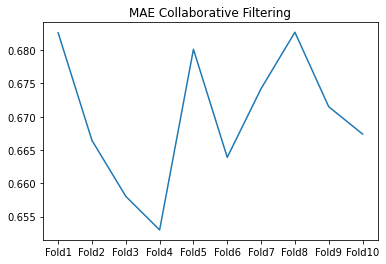

In [89]:
label_fold = ['Fold1','Fold2','Fold3','Fold4','Fold5','Fold6','Fold7','Fold8','Fold9','Fold10']
plt.plot(label_fold,mae_cf)
plt.title('MAE Collaborative Filtering')

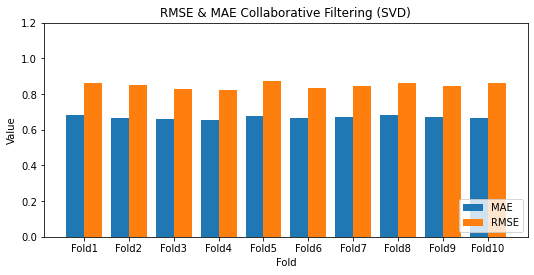

In [55]:
label_fold = ['Fold1','Fold2','Fold3','Fold4','Fold5','Fold6','Fold7','Fold8','Fold9','Fold10']
X_axis = np.arange(len(label_fold))
plt.figure(figsize=(cm_to_inch(22),cm_to_inch(10)))  
plt.bar(X_axis - 0.2, mae_cf, 0.4, label = 'MAE')
plt.bar(X_axis + 0.2, rmse_cf, 0.4, label = 'RMSE')
plt.xticks(X_axis, label_fold)
plt.xlabel("Fold")
plt.ylabel("Value")
plt.ylim([0, 1.2])
plt.title("RMSE & MAE Collaborative Filtering (SVD)")
plt.legend(loc="lower right")
plt.show()

In [ ]:
label_fold = ['Fold1','Fold2','Fold3','Fold4','Fold5','Fold6','Fold7','Fold8','Fold9','Fold10']
plt.plot(label_fold,rmse_cf)
plt.title('RMSE Collaborative Filtering')

### Testing Model Content Based Filtering (Cosine Similarity) with 10 Fold

In [31]:
def content_based_testing(dt_testing,dt_training):
    rating_pred = []
    for index,row in dt_testing.iterrows():
        user_id = row['user_id']
        destination_id = row['destination_id']
        rating_pred.append(content_based_recommender(user_id,destination_id,dt_training))
    return rating_pred

In [32]:
begin_time = datetime.datetime.now()
print(1)
rating_pred_cb_fold1 = content_based_testing(dt_fold_testing1,dt_fold_training1)
print(2)
rating_pred_cb_fold2 = content_based_testing(dt_fold_testing2,dt_fold_training2)
print(3)
rating_pred_cb_fold3 = content_based_testing(dt_fold_testing3,dt_fold_training3)
print(4)
rating_pred_cb_fold4 = content_based_testing(dt_fold_testing4,dt_fold_training4)
print(5)
rating_pred_cb_fold5 = content_based_testing(dt_fold_testing5,dt_fold_training5)
print(6)
rating_pred_cb_fold6 = content_based_testing(dt_fold_testing6,dt_fold_training6)
print(7)
rating_pred_cb_fold7 = content_based_testing(dt_fold_testing7,dt_fold_training7)
print(8)
rating_pred_cb_fold8 = content_based_testing(dt_fold_testing8,dt_fold_training8)
print(9)
rating_pred_cb_fold9 = content_based_testing(dt_fold_testing9,dt_fold_training9)
print(10)
rating_pred_cb_fold10 = content_based_testing(dt_fold_testing10,dt_fold_training10)
print(datetime.datetime.now() - begin_time)

1
2
3
4
5
6
7
8
9
10
0:02:15.279913


### Calculate MAE and RMSE Model Content-Based Filtering (Cosine Similarity) for Each Fold 

In [33]:
mae_cb = []
rmse_cb = []
print('MAE and RMSE fold 1')
mae_cb_fold1 = find_mae(rating_pred_cb_fold1,y_test1)
rmse_cb_fold1 = find_rmse(rating_pred_cb_fold1,y_test1)
print(mae_cb_fold1)
print(rmse_cb_fold1)
mae_cb.append(mae_cb_fold1)
rmse_cb.append(rmse_cb_fold1)

MAE and RMSE fold 1
0.7267415203985395
0.9231218086341816


In [34]:
print('MAE and RMSE fold 2')
mae_cb_fold2 = find_mae(rating_pred_cb_fold2,y_test2)
rmse_cb_fold2 = find_rmse(rating_pred_cb_fold2,y_test2)
print(mae_cb_fold2)
print(rmse_cb_fold2)
mae_cb.append(mae_cb_fold2)
rmse_cb.append(rmse_cb_fold2)

MAE and RMSE fold 2
0.726661490096561
0.9235315249514542


In [35]:
print('MAE and RMSE fold 3')
mae_cb_fold3 = find_mae(rating_pred_cb_fold3,y_test3)
rmse_cb_fold3 = find_rmse(rating_pred_cb_fold3,y_test3)
print(mae_cb_fold3)
print(rmse_cb_fold3)
mae_cb.append(mae_cb_fold3)
rmse_cb.append(rmse_cb_fold3)

MAE and RMSE fold 3
0.7096571046666634
0.8990377141752569


In [36]:
print('MAE and RMSE fold 4')
mae_cb_fold4 = find_mae(rating_pred_cb_fold4,y_test4)
rmse_cb_fold4 = find_rmse(rating_pred_cb_fold4,y_test4)
print(mae_cb_fold4)
print(rmse_cb_fold4)
mae_cb.append(mae_cb_fold4)
rmse_cb.append(rmse_cb_fold4)

MAE and RMSE fold 4
0.6815663266321168
0.8736378075640913


In [37]:
print('MAE and RMSE fold 5')
mae_cb_fold5 = find_mae(rating_pred_cb_fold5,y_test5)
rmse_cb_fold5 = find_rmse(rating_pred_cb_fold5,y_test5)
print(mae_cb_fold5)
print(rmse_cb_fold5)
mae_cb.append(mae_cb_fold5)
rmse_cb.append(rmse_cb_fold5)

MAE and RMSE fold 5
0.7124543710373787
0.9241380630750241


In [38]:
print('MAE and RMSE fold 6')
mae_cb_fold6 = find_mae(rating_pred_cb_fold6,y_test6)
rmse_cb_fold6 = find_rmse(rating_pred_cb_fold6,y_test6)
print(mae_cb_fold6)
print(rmse_cb_fold6)
mae_cb.append(mae_cb_fold6)
rmse_cb.append(rmse_cb_fold6)

MAE and RMSE fold 6
0.7067594900433268
0.8982259626685766


In [39]:
print('MAE and RMSE fold 7')
mae_cb_fold7 = find_mae(rating_pred_cb_fold7,y_test7)
rmse_cb_fold7 = find_rmse(rating_pred_cb_fold7,y_test7)
print(mae_cb_fold7)
print(rmse_cb_fold7)
mae_cb.append(mae_cb_fold7)
rmse_cb.append(rmse_cb_fold7)

MAE and RMSE fold 7
0.7131913770450469
0.9116507650944498


In [40]:
print('MAE and RMSE fold 8')
mae_cb_fold8 = find_mae(rating_pred_cb_fold8,y_test8)
rmse_cb_fold8 = find_rmse(rating_pred_cb_fold8,y_test8)
print(mae_cb_fold8)
print(rmse_cb_fold8)
mae_cb.append(mae_cb_fold8)
rmse_cb.append(rmse_cb_fold8)

MAE and RMSE fold 8
0.7161382344107525
0.9239981548803483


In [41]:
print('MAE and RMSE fold 9')
mae_cb_fold9 = find_mae(rating_pred_cb_fold9,y_test9)
rmse_cb_fold9 = find_rmse(rating_pred_cb_fold9,y_test9)
print(mae_cb_fold9)
print(rmse_cb_fold9)
mae_cb.append(mae_cb_fold9)
rmse_cb.append(rmse_cb_fold9)

MAE and RMSE fold 9
0.7089456173050982
0.8999062523203379


In [42]:
print('MAE and RMSE fold 10')
mae_cb_fold10 = find_mae(rating_pred_cb_fold10,y_test10)
rmse_cb_fold10 = find_rmse(rating_pred_cb_fold10,y_test10)
print(mae_cb_fold10)
print(rmse_cb_fold10)
mae_cb.append(mae_cb_fold10)
rmse_cb.append(rmse_cb_fold10)

MAE and RMSE fold 10
0.7204703328740296
0.9272006307335694


Text(0.5, 1.0, 'MAE Content Based Filtering')

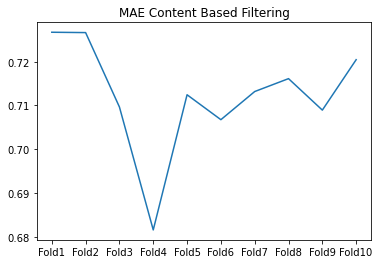

In [43]:
label_fold = ['Fold1','Fold2','Fold3','Fold4','Fold5','Fold6','Fold7','Fold8','Fold9','Fold10']
plt.plot(label_fold,mae_cb)
plt.title('MAE Content Based Filtering')

Text(0.5, 1.0, 'RMSE Content Based Filtering')

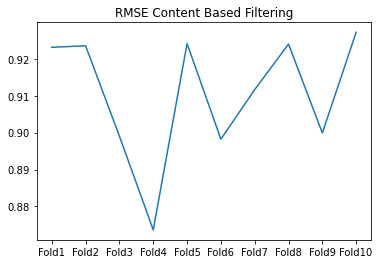

In [44]:
label_fold = ['Fold1','Fold2','Fold3','Fold4','Fold5','Fold6','Fold7','Fold8','Fold9','Fold10']
plt.plot(label_fold,rmse_cb)
plt.title('RMSE Content Based Filtering')

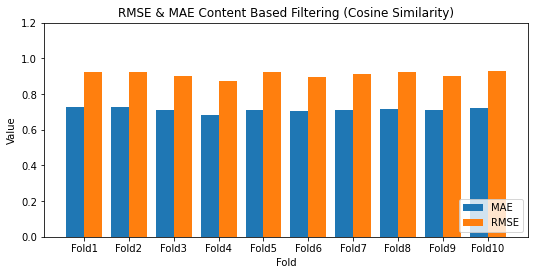

In [54]:
label_fold = ['Fold1','Fold2','Fold3','Fold4','Fold5','Fold6','Fold7','Fold8','Fold9','Fold10']
X_axis = np.arange(len(label_fold))
plt.figure(figsize=(cm_to_inch(22),cm_to_inch(10)))  
plt.bar(X_axis - 0.2, mae_cb, 0.4, label = 'MAE')
plt.bar(X_axis + 0.2, rmse_cb, 0.4, label = 'RMSE')
plt.xticks(X_axis, label_fold)
plt.xlabel("Fold")
plt.ylabel("Value")
plt.ylim([0, 1.2])
plt.title("RMSE & MAE Content Based Filtering (Cosine Similarity)")
plt.legend(loc="lower right")
plt.show()

### Testing Model Demographic Filtering (Support Vector Machine) with 10 Fold

In [22]:
def demographic_filtering_testing(dt_testing,dt_training):
    rating_pred = []
    for index,row in dt_testing.iterrows():
        user_id = row['user_id']
        destination_id = row['destination_id']
        print(user_id,destination_id)
        rating_pred.append(demographic_filtering_using_svm(user_id,destination_id,dt_training))
    return rating_pred

In [23]:
begin_time = datetime.datetime.now()
print(1)
rating_pred_df_fold1 = demographic_filtering_testing(dt_fold_testing1,dt_fold_training1)
print(datetime.datetime.now() - begin_time)

1
3031 41
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3109 21
SVC(C=1, decision_function_shape='ovo', gamma=1)
1913 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1048 75
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2261 50
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2833 4
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
2574 8
SVC(C=1, decision_function_shape='ovo', gamma=1)
682 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2930 62
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1170 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1968 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
929 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
760 77
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3395 29
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3097 31
SVC(C=1, decision_function_shape='ovo', gamma=1)
1892 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
551 17
SVC(C=1, decision_functi

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2762 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
3234 43
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1554 110
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
929 51
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2361 20
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1768 45
SVC(C=10, decision_function_shape='ovo', gamma=1)
1277 110
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
469 11
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
512 6
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
84 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1064 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
796 11
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2760 50
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
668 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
2956 34
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
1599 1

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1655 69
SVC(C=1, decision_function_shape='ovo', gamma=1)
1214 48
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
273 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3369 94
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
1695 50
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
3339 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3314 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1269 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3037 43
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
156 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3120 27
SVC(C=1, decision_function_shape='ovo', gamma=1)
1484 82
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2881 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
1835 43
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2860 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3308 68
SVC(C=0.1, decision_fun

SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
92 102
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
3453 85
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
524 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
424 77
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2449 91
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
829 105
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2267 64
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2953 46
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1125 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
1508 4
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
2513 51
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2254 68
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1230 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
2134 1
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3101 112
SVC(C=0.1, decisi

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2185 12
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
141 58
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1017 44
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
710 16
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
216 82
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
523 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2011 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
704 114
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1404 111
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
720 31
SVC(C=1, decision_function_shape='ovo', gamma=1)
1806 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
44 42
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1346 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
984 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
3002 60
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2877 3
SVC(C=0.1, decisi

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
708 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
1678 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1662 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
886 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
560 83
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3287 70
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
875 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
973 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
3403 51
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
385 114
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2818 38
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1337 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
2338 39
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2084 11
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1971 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2749 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
1310 

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1046 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2600 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2286 5
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1428 26
SVC(C=10, decision_function_shape='ovo', gamma=1)
2107 58
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3472 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
585 93
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3024 77
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3414 85
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2119 80
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3159 69
SVC(C=1, decision_function_shape='ovo', gamma=1)
2111 8
SVC(C=1, decision_function_shape='ovo', gamma=1)
1398 54
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2241 41
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2570 28
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3113 72
SVC(C=1, decision_function_shape='ovo', gamma=1)

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
1300 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
1749 62
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
586 68
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1262 36
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
782 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
3295 34
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2314 42
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1679 12
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1573 51
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2557 63
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2687 65
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
835 94
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
1294 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
2359 49
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
1514 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3374 11
SVC(C=0.1, deci

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
683 5
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3166 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
252 34
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
3226 46
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1472 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
870 4
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
219 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2203 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2764 79
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
29 66
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
2112 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
460 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
2423 26
SVC(C=10, decision_function_shape='ovo', gamma=1)
3450 6
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
284 104
SVC(C=0.1, decision_function_shape

SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1566 46
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3032 70
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2648 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2007 20
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
52 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1547 4
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
3310 34
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
813 79
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1015 58
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1839 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
219 41
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2366 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3153 58
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
548 26
SVC(C=10, decision_function_shape='ovo', gamma=1)
2867 78
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmo

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
3317 73
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3202 67
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2694 38
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1572 20
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3219 47
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2648 94
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
3159 80
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2091 2
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1076 43
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
182 41
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3386 26
SVC(C=10, decision_function_shape='ovo', gamma=1)
1533 70
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
707 55
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
135 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1953 85
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
928 1
SVC(C=0.1, decision_fun

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2028 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2080 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
1484 26
SVC(C=10, decision_function_shape='ovo', gamma=1)
176 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
2899 26
SVC(C=10, decision_function_shape='ovo', gamma=1)
3472 69
SVC(C=1, decision_function_shape='ovo', gamma=1)
2608 26
SVC(C=10, decision_function_shape='ovo', gamma=1)
3186 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
278 61
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1183 48
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3063 70
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2035 66
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
2967 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
440 54
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3113 43
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3393 33
SVC(C=0.1, decision_function_

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
622 5
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
315 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2640 115
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2586 90
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3117 43
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2928 42
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2201 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2601 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
2240 47
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1624 21
SVC(C=1, decision_function_shape='ovo', gamma=1)
2086 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1177 56
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2658 26
SVC(C=10, decision_function_shape='ovo', gamma=1)
1734 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1014 4
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
3049 24
SVC(C=0.1, decision_function

In [25]:
begin_time = datetime.datetime.now()
print(2)
rating_pred_df_fold2 = demographic_filtering_testing(dt_fold_testing2,dt_fold_training2)
print(3)
rating_pred_df_fold3 = demographic_filtering_testing(dt_fold_testing3,dt_fold_training3)
print(4)
rating_pred_df_fold4 = demographic_filtering_testing(dt_fold_testing4,dt_fold_training4)
print(5)
rating_pred_df_fold5 = demographic_filtering_testing(dt_fold_testing5,dt_fold_training5)
print(datetime.datetime.now() - begin_time)

2
629 45
SVC(C=1, decision_function_shape='ovo', gamma=1)
1069 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2892 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1780 102
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1224 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
238 31
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1862 5
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1298 41
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1090 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2719 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
302 48
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1413 78
SVC(C=1, decision_function_shape='ovo', gamma=1)
3028 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
36 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
844 93
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1812 31
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1312 33
SVC(C=0.1, decision

SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
529 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2184 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2015 39
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2142 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2818 27
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
85 9
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2374 19
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
938 10
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
3088 29
SVC(C=10, decision_function_shape='ovo', gamma=1)
3165 34
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
3205 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
65 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1038 8
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
498 9
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1078 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1586 18
SVC(C=0.1

SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
1309 40
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1553 78
SVC(C=1, decision_function_shape='ovo', gamma=1)
2342 78
SVC(C=1, decision_function_shape='ovo', gamma=1)
1917 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3155 45
SVC(C=1, decision_function_shape='ovo', gamma=1)
990 51
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2325 45
SVC(C=1, decision_function_shape='ovo', gamma=1)
1308 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2721 87
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3227 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2002 78
SVC(C=1, decision_function_shape='ovo', gamma=1)
2106 65
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2572 58
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
995 5
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2767 17
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
3220 4

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
1171 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2180 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
703 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2106 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
846 48
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2649 17
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
3067 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1319 1
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
68 50
SVC(C=10, decision_function_shape='ovo', gamma=1)
1761 64
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
229 31
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1500 11
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
963 102
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1194 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1010 90
SVC(C=0.1, decision_function_sh

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
828 113
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2256 58
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
306 34
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
3222 84
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
449 74
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
314 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2015 103
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1106 58
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
1593 48
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
705 78
SVC(C=1, decision_function_shape='ovo', gamma=1)
2368 94
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
196 88
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
457 54
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
3124 8
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
3051 21
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
824 24
SVC(C=0.1, decision_function_sh

SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1470 61
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
1004 17
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
2461 50
SVC(C=10, decision_function_shape='ovo', gamma=1)
3473 75
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1371 38
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
123 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1845 66
SVC(C=10, decision_function_shape='ovo', gamma=1)
293 78
SVC(C=1, decision_function_shape='ovo', gamma=1)
774 44
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2174 46
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1351 28
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1791 89
SVC(C=0.1, decision_function_shape='ovo', gamma=0.1, kernel='poly')
1699 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
520 45
SVC(C=1, decision_function_shape='ovo', gamma=1)
889 6
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2337 9
SVC(C=0.1, decis

SVC(C=0.1, decision_function_shape='ovo', gamma=0.1, kernel='poly')
1924 112
SVC(C=10, decision_function_shape='ovo', gamma=1)
3240 57
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
183 4
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3103 48
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2853 66
SVC(C=10, decision_function_shape='ovo', gamma=1)
824 36
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1413 102
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
3038 96
SVC(C=1, decision_function_shape='ovo', gamma=1)
1616 1
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3246 8
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
1827 39
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3168 64
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
3262 17
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
21 17
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
1130 37
SVC(C=1, decision_function_shape='o

SVC(C=0.1, decision_function_shape='ovo', gamma=0.1, kernel='poly')
1251 87
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2946 77
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2786 11
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1215 110
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2912 9
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1820 64
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1675 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2588 17
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
2055 26
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2541 73
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2596 48
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
476 5
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
193 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2396 1
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2422 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)


SVC(C=0.1, decision_function_shape='ovo', gamma=1)
289 102
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
3429 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2845 17
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
3163 5
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2123 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2498 46
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1486 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
801 50
SVC(C=10, decision_function_shape='ovo', gamma=1)
3266 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3076 94
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
1259 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1764 62
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1406 20
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1797 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1458 78
SVC(C=1, decision_function_shape='ovo', gamma=1

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
917 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
291 9
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3111 68
SVC(C=1, decision_function_shape='ovo', gamma=1)
2157 58
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
1170 70
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2485 1
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
109 65
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1343 45
SVC(C=1, decision_function_shape='ovo', gamma=1)
2189 78
SVC(C=1, decision_function_shape='ovo', gamma=1)
3221 31
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1535 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2620 1
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
357 84
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
740 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2086 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3238 48
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
853 70
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
1182 34
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
3089 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1329 17
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
505 23
SVC(C=10, decision_function_shape='ovo', gamma=1)
1098 68
SVC(C=1, decision_function_shape='ovo', gamma=1)
2282 80
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2279 10
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
1474 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2277 68
SVC(C=1, decision_function_shape='ovo', gamma=1)
41 62
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1031 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
893 4
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3404 78
SVC(C=1, decision_function_shape='ovo', gamma=1)
2957 28
SVC(C=0.1, d

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1387 11
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1393 66
SVC(C=10, decision_function_shape='ovo', gamma=1)
518 70
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
3224 58
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
3151 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2990 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1977 84
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2099 45
SVC(C=1, decision_function_shape='ovo', gamma=1)
480 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1431 78
SVC(C=1, decision_function_shape='ovo', gamma=1)
837 4
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1847 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2954 60
SVC(C=1, decision_function_shape='ovo', gamma=1)
1070 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3338 56
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
706 14
SVC(C=0.1, decision_function_shape='ovo', gamm

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3440 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2647 102
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2500 64
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2754 72
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
3488 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
3055 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
232 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
684 28
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
899 51
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1767 115
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2982 55
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
1135 68
SVC(C=1, decision_function_shape='ovo', gamma=1)
866 51
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1810 68
SVC(C=1, decision_function_shape='ovo', gamma=1)
3329 78
SVC(C=1, decision_function_shape='ovo', gamma=1)
2457 51
SVC(C=0.1, decision_functi

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2773 108
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3055 21
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1834 93
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
631 74
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
1507 45
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
743 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1654 66
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1136 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2180 26
SVC(C=0.1, decision_function_shape='ovo', gamma=0.1, kernel='poly')
2686 27
SVC(C=1, decision_function_shape='ovo', gamma=1)
976 21
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1237 23
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
519 79
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2910 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2155 68
SVC(C=1, decision_function_shape='ovo', gamm

SVC(C=1, decision_function_shape='ovo', gamma=0.1)
381 45
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3255 9
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
3484 84
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
239 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
541 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3448 62
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3490 9
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
3263 34
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2801 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1927 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
643 85
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1498 3
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
1145 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3437 93
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
3402 9
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
3291 34
SVC(C=0

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3060 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3051 64
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
3418 85
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2097 34
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1532 6
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
858 70
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2549 65
SVC(C=1, decision_function_shape='ovo', gamma=1)
1817 26
SVC(C=0.1, decision_function_shape='ovo', gamma=0.1, kernel='poly')
669 21
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2093 63
SVC(C=10, decision_function_shape='ovo', gamma=1)
2040 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
974 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1442 23
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
280 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1826 1
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
48

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
273 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
928 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
741 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1276 81
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1383 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2282 9
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
67 9
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
3191 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
11 72
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2201 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3462 22
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1130 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1078 31
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2118 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1942 62
SVC(C=0.1, decision_function_s

SVC(C=0.1, decision_function_shape='ovo', gamma=0.1, kernel='poly')
3346 26
SVC(C=0.1, decision_function_shape='ovo', gamma=0.1, kernel='poly')
1168 94
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
533 114
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2574 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1832 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
1572 11
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
2503 3
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2208 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2483 4
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2079 31
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1330 80
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
1714 110
SVC(C=10, decision_function_shape='ovo', gamma=1)
476 68
SVC(C=1, decision_function_shape='ovo', gamma=1)
2546 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2581 16
SVC(C=1, decision_function_shape='o

SVC(C=1, decision_function_shape='ovo', gamma=1)
1123 61
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
29 46
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2844 31
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2478 88
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1400 82
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
1612 51
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
169 73
SVC(C=10, decision_function_shape='ovo', gamma=1)
543 6
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1096 70
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1601 75
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
455 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2848 20
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2342 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1742 48
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
737 68
SVC(C=1, decision_function_shape='ovo', gamma=1)
232 5
SVC(C=1, decision_function_sh

SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
3486 56
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2709 82
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
2090 56
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1294 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
689 11
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
1901 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1636 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1270 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2076 48
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2792 80
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
1274 62
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1605 3
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
1624 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
310 74
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
1216 26
SVC(C=0.1, decision_functi

SVC(C=1, decision_function_shape='ovo', gamma=1)
2705 48
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1345 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
213 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2931 64
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2560 8
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
1201 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1963 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1238 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1408 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1488 77
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
571 61
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2929 93
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
364 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2331 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
618 75
SVC(C=0.1, decision_function_shape='ovo', gamma=

SVC(C=1, decision_function_shape='ovo', gamma=1)
2583 66
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1555 27
SVC(C=1, decision_function_shape='ovo', gamma=1)
2151 2
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2452 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1699 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3047 58
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
1531 51
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1254 68
SVC(C=1, decision_function_shape='ovo', gamma=1)
2179 85
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3243 72
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
3453 20
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1263 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
3003 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
982 11
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
173 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1895 56
SVC(C=0.1, decision_function_shape='ovo', gamma

SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
2410 65
SVC(C=1, decision_function_shape='ovo', gamma=1)
1634 62
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2575 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2258 42
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
735 36
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2950 6
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1332 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1901 16
SVC(C=1, decision_function_shape='ovo', gamma=1)
1418 6
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1663 1
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1509 56
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2749 10
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
1752 94
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2449 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1751 110
SVC(C=10, decision_function_shape='o

SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
66 88
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2948 77
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
976 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1668 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
7 21
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2129 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
619 108
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
539 1
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2864 61
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
432 23
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
846 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3083 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
712 11
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
1584 82
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
1252 61
SVC(C=10, decision_

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3400 109
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
718 64
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1803 39
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
621 64
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2294 58
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
101 43
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2799 3
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
1841 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
419 61
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1278 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2004 8
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
3370 50
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2085 39
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
851 5
SVC(C=1, decision_function_shape='ovo', gamma=1)
1599 80
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
8

SVC(C=1, decision_function_shape='ovo', gamma=1)
546 9
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
61 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1628 65
SVC(C=1, decision_function_shape='ovo', gamma=1)
667 72
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
450 55
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2329 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2385 62
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3249 9
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2046 78
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
1182 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1560 94
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1367 74
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
3485 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2649 58
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
2628 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2864 24
SVC(C=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
445 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
491 97
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
432 9
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
3027 102
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
442 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3195 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2382 77
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3418 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2815 105
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
3237 48
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
80 70
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1364 56
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
673 80
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2951 64
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
104 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2305 58
SVC(C=0.1, decision_functi

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
495 57
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
554 51
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2404 63
SVC(C=10, decision_function_shape='ovo', gamma=1)
1124 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1647 68
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
342 5
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1249 51
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1016 32
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
611 4
SVC(C=10, decision_function_shape='ovo', gamma=1)
1411 5
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
341 39
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1624 45
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1881 68
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2738 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1620 27
SVC(C=0.1, decision_function_shape='o

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2260 85
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1173 56
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1134 20
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3376 85
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1007 58
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1191 9
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1414 82
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
69 5
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2287 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1089 80
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1368 78
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
3327 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
67 65
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
303 48
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3185 57
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2677 104
SVC(C=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
998 4
SVC(C=10, decision_function_shape='ovo', gamma=1)
3137 79
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3234 55
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
187 51
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1366 26
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1099 77
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3432 72
SVC(C=1, decision_function_shape='ovo', gamma=1)
1572 27
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
279 70
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
597 102
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2615 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2659 34
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1376 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1632 1
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
910 24
SVC(C=0.1, decision_function_shape='ovo',

SVC(C=1, decision_function_shape='ovo', gamma=0.1)
3157 9
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1607 79
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1204 6
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
975 1
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2737 31
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3369 9
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2552 46
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
701 78
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
2759 21
SVC(C=1, decision_function_shape='ovo', gamma=1)
1850 16
SVC(C=1, decision_function_shape='ovo', gamma=1)
472 43
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
238 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3115 31
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3213 31
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
903 51
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoi

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2323 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2427 60
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
94 66
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='poly')
3498 113
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2621 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2649 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3123 68
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1364 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2672 85
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2749 58
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3361 50
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
50 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
919 12
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1163 63
SVC(C=10, decision_function_shape='ovo', gamma=1)
222 17
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
292 16
SVC(C=1, decision_functio

SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2178 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1866 79
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3156 65
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
96 26
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
28 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1495 26
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3010 68
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1150 85
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1990 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
939 11
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2928 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
473 70
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2311 101
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
152 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
817 39
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
895 28
SVC(C=0.1, decision_function_sh

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2010 68
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
665 41
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1045 27
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
781 77
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1210 41
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2460 72
SVC(C=1, decision_function_shape='ovo', gamma=1)
1401 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
989 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
446 23
SVC(C=1, decision_function_shape='ovo', gamma=1)
2029 9
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1895 82
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
2178 41
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
225 4
SVC(C=10, decision_function_shape='ovo', gamma=1)
3411 28
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
159 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2836 39
SVC(C=0.1, decis

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2736 65
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
209 26
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3114 31
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2421 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
288 58
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
599 8
SVC(C=1, decision_function_shape='ovo', gamma=1)
3096 82
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
3081 94
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1216 23
SVC(C=1, decision_function_shape='ovo', gamma=1)
3418 34
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
41 1
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
925 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3247 34
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
550 80
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2630 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3075 70
SVC(C=0.1, decision_function_

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
811 84
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2139 62
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2597 11
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2836 78
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
3027 31
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3493 86
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
3074 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1461 78
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
675 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2281 89
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
381 102
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1801 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
44 85
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2127 37
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
608 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
772 23
SVC(C=1, dec

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1807 11
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1249 72
SVC(C=1, decision_function_shape='ovo', gamma=1)
1767 55
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
3005 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1768 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2766 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3191 56
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1186 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
268 36
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
951 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2154 26
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1510 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
196 78
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
2269 85
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1192 94
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2388 12
SVC(C=0.1, decision_function_s

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3255 110
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1919 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2509 9
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2409 45
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3305 65
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
34 112
SVC(C=10, decision_function_shape='ovo', gamma=1)
2819 4
SVC(C=10, decision_function_shape='ovo', gamma=1)
2437 5
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2277 4
SVC(C=10, decision_function_shape='ovo', gamma=1)
109 82
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
2437 10
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1207 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1513 39
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2569 41
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
150 14
SVC(C=0.1, decision_function_sha

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
591 1
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2388 21
SVC(C=1, decision_function_shape='ovo', gamma=1)
1723 36
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
1277 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1348 102
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1271 79
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
728 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
617 80
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
3385 109
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2343 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2939 19
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
3190 48
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
730 34
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
116 60
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
713 24
SVC(C=0.1, decisi

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
973 73
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
493 16
SVC(C=1, decision_function_shape='ovo', gamma=1)
2521 37
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
822 4
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
359 45
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1452 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2824 8
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1617 75
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3143 51
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3216 56
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3212 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2317 91
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2877 56
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
705 87
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1002 91
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2874 85
SVC(C=1, decision_function_sha

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
803 75
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2242 94
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
3180 5
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2928 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
1742 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
738 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
197 31
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2551 91
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2660 68
SVC(C=1, decision_function_shape='ovo', gamma=1)
1096 78
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1393 9
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2456 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3116 34
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2648 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2829 61
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2740 26
SVC(C=0.1, decision_function_shape='ovo',

SVC(C=10, decision_function_shape='ovo', gamma=1)
1528 95
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2448 37
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2283 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2785 93
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
218 50
SVC(C=10, decision_function_shape='ovo', gamma=1)
3084 28
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2648 79
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2998 88
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3158 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2700 34
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2933 9
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2329 31
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
601 70
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
934 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1706 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1059 93
SVC(C=0.1, decision_functi

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
208 96
SVC(C=1, decision_function_shape='ovo', gamma=1)
747 5
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
794 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1551 97
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1062 26
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
255 62
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
3327 42
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1542 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
169 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2065 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
362 41
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
25 81
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2430 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2262 26
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1596 5
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2246 64
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2637 33
SV

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2682 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2371 2
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3131 45
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3488 65
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1350 63
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1915 28
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3209 4
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3157 34
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2835 4
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1843 43
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1555 68
SVC(C=1, decision_function_shape='ovo', gamma=1)
2857 38
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1461 47
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1970 78
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2030 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3154 72
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
321 24
SVC(

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
633 63
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3351 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3338 78
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2808 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2623 80
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
143 1
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
465 8
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3127 28
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1970 46
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1005 117
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
220 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3472 47
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
683 60
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
447 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1868 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
38 24
SVC(C=0.1, decision_function_shape='ovo', gam

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1672 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1002 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1274 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
1610 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1809 4
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2220 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1002 45
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
502 78
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2614 9
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
442 55
SVC(C=1, decision_function_shape='ovo', gamma=1)
3195 31
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2945 70
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
320 85
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1485 26
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2404 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2097 61
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigm

SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
208 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
838 48
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1583 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
347 9
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3247 62
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
1899 99
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2495 68
SVC(C=1, decision_function_shape='ovo', gamma=1)
1599 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2452 65
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2468 93
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1734 21
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1266 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1573 20
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2214 80
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1621 102
SVC(C=0.1, decision_function_shape='ovo', gamma=1, ker

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
695 77
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
976 41
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1115 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1331 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2269 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
972 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
487 85
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2323 48
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2055 78
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
616 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2783 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
69 60
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
1848 78
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1445 37
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3050 48
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2956 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2596 9
SVC

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
31 75
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1936 5
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2134 60
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
3478 39
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
498 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
97 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2715 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
2034 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1359 10
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2692 5
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
3261 34
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2584 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
847 22
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
471 77
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2312 59
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
503 39
SVC(C=0.1, decision_function_shape='ovo', ga

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
207 9
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3016 63
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3075 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
3187 110
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
927 45
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1689 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1934 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1332 38
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
569 48
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1044 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
184 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
702 63
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3 47
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
853 79
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2064 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
2131 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1042 47
SVC(C=1, deci

SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
776 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1763 78
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1005 1
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
1168 16
SVC(C=1, decision_function_shape='ovo', gamma=1)
1904 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
99 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
214 48
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2332 80
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
134 82
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2417 43
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3091 61
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
943 1
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
434 22
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
643 70
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3138 33
SVC(C=0.1, decision_functio

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2868 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
531 23
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1441 17
SVC(C=1, decision_function_shape='ovo', gamma=1)
568 78
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2061 77
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3089 80
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2770 48
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
916 39
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2240 80
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1431 68
SVC(C=1, decision_function_shape='ovo', gamma=1)
2830 31
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
798 42
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2362 63
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2633 61
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1274 50
SVC(C=10, decision_function_shape='ovo', gamma=1)
2960 14
SVC(C=0.1, decision_function

In [57]:
print(6)
rating_pred_df_fold6 = demographic_filtering_testing(dt_fold_testing6,dt_fold_training6)

6
659 65
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2906 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2320 102
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2904 41
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
1366 5
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2369 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1428 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3480 78
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1064 120
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3111 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3413 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
601 34
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
572 77
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2137 31
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
493 51
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1336 34
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1520 15
SVC(C=0

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
592 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
775 9
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
2156 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1151 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1370 113
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2759 89
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
692 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
125 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1175 86
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
1585 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3251 28
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
322 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3368 97
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1686 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
732 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1663 45
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2074 13
SVC

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
3448 85
SVC(C=10, decision_function_shape='ovo', gamma=1)
752 64
SVC(C=1, decision_function_shape='ovo', gamma=1)
2292 32
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
378 17
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
3259 77
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
618 79
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
3062 48
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
310 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1431 17
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
281 50
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
1091 17
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1157 51
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2251 50
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
883 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
574 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1671 55
SVC(C=0.1, decision_function_shape='ovo'

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2795 102
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
328 77
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3469 62
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2528 9
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
1366 37
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3093 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3430 45
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
640 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3097 58
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
3199 63
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3208 21
SVC(C=1, decision_function_shape='ovo', gamma=1)
1211 116
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1422 55
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2132 80
SVC(C=10, decision_function_shape='ovo', gamma=1)
1748 58
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
2951 78
SVC(C=10, decision

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
561 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1252 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
847 11
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2728 11
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
1117 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1934 11
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
966 102
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2867 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1178 17
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
415 4
SVC(C=1, decision_function_shape='ovo', gamma=1)
3406 34
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1594 102
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
154 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2327 4
SVC(C=1, decision_function_shape='ovo', gamma=1)
218 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
993 15
SVC(C=0.1, decision_funct

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1256 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3029 87
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2116 102
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
314 85
SVC(C=10, decision_function_shape='ovo', gamma=1)
1996 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2649 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2208 43
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3307 113
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1496 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
857 31
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2916 85
SVC(C=10, decision_function_shape='ovo', gamma=1)
874 17
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
3419 58
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
3131 73
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1602 111
SVC(C=1, decision_function_shape='ovo', gamma=1)
824 34
SVC(C=0.1, decision_fu

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2934 106
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
734 9
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
2201 60
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
2064 8
SVC(C=1, decision_function_shape='ovo', gamma=1)
2868 79
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
2154 78
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
372 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1665 45
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1132 43
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
484 8
SVC(C=1, decision_function_shape='ovo', gamma=1)
2092 23
SVC(C=10, decision_function_shape='ovo', gamma=1)
343 75
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
8 9
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
1775 1
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
464 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
114 3
SVC(C=0.1, de

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2176 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1226 120
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1210 85
SVC(C=10, decision_function_shape='ovo', gamma=1)
156 103
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2065 95
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1018 55
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
910 17
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2132 36
SVC(C=1, decision_function_shape='ovo', gamma=1)
2543 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2444 78
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
281 31
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
347 41
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
447 80
SVC(C=10, decision_function_shape='ovo', gamma=1)
3191 46
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3437 9
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
1227 64
SVC(C=1, decision_func

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3145 16
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
3170 85
SVC(C=10, decision_function_shape='ovo', gamma=1)
3285 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1652 72
SVC(C=1, decision_function_shape='ovo', gamma=1)
195 115
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2835 86
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
389 62
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1689 1
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
3191 9
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
1975 9
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
1209 47
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2422 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2078 86
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
2410 65
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3093 1
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2733 17
SVC(C=1, decision_funct

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1156 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1058 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1728 56
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
871 9
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
897 36
SVC(C=1, decision_function_shape='ovo', gamma=1)
2605 12
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1429 78
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
578 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1454 27
SVC(C=1, decision_function_shape='ovo', gamma=1)
1107 64
SVC(C=1, decision_function_shape='ovo', gamma=1)
882 110
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1684 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1664 80
SVC(C=10, decision_function_shape='ovo', gamma=1)
783 68
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1824 81
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
19 43
SVC(C=0.1, decision_function_shape='ovo', gamma=1

SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1824 62
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
4 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2132 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2128 77
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1494 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
509 58
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
2381 78
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2745 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1867 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2049 41
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
1351 43
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
878 51
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
730 46
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1912 31
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
447 61
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1869 24
S

SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
2137 38
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
783 89
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1232 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3278 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2491 27
SVC(C=1, decision_function_shape='ovo', gamma=1)
3497 64
SVC(C=1, decision_function_shape='ovo', gamma=1)
2687 62
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2785 59
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
3243 90
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
575 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2402 78
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2788 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
855 8
SVC(C=1, decision_function_shape='ovo', gamma=1)
1575 68
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1176 97
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2997 15
SVC(C=0.1, d

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2669 17
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2419 17
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1341 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2324 20
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2460 68
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
540 70
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2667 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
925 28
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
437 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2209 55
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
458 45
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2958 17
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1803 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
721 20
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2423 31
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3076 64
SVC(C=1, decision_function_shape='ovo', gamma=1)
2935 38
SVC(C

In [26]:
begin_time = datetime.datetime.now()
print(7)
rating_pred_df_fold7 = demographic_filtering_testing(dt_fold_testing7,dt_fold_training7)
print(8)
rating_pred_df_fold8 = demographic_filtering_testing(dt_fold_testing8,dt_fold_training8)
print(datetime.datetime.now() - begin_time)

7
1510 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
520 48
SVC(C=1, decision_function_shape='ovo', gamma=1)
2122 17
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
1968 1
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1688 94
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
51 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1175 48
SVC(C=1, decision_function_shape='ovo', gamma=1)
2412 58
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1529 17
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
1246 84
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1609 17
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
277 8
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1334 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3140 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1728 102
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
181 102
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
529 28
SVC(C=0.1, decision_functio

SVC(C=10, decision_function_shape='ovo', gamma=0.1)
435 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3074 70
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
1283 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3341 27
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3253 48
SVC(C=1, decision_function_shape='ovo', gamma=1)
1134 70
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
3497 21
SVC(C=1, decision_function_shape='ovo', gamma=1)
1350 66
SVC(C=1, decision_function_shape='ovo', gamma=1)
385 48
SVC(C=1, decision_function_shape='ovo', gamma=1)
2841 63
SVC(C=10, decision_function_shape='ovo', gamma=1)
58 66
SVC(C=1, decision_function_shape='ovo', gamma=1)
1825 66
SVC(C=1, decision_function_shape='ovo', gamma=1)
2272 65
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
1080 50
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2311 77
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3 70
SVC(C=10, decision_function_shape='ovo',

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
994 39
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1865 68
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
670 5
SVC(C=10, decision_function_shape='ovo', gamma=1)
1622 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
598 64
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
517 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
107 120
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
526 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
22 113
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3414 34
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1849 94
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
2344 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2699 56
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2610 85
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
292 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2472 58
SVC(C=0.1, decision_function_shape='ovo', ga

SVC(C=1, decision_function_shape='ovo', gamma=1)
619 5
SVC(C=10, decision_function_shape='ovo', gamma=1)
1854 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2851 86
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2804 46
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2866 93
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2523 26
SVC(C=1, decision_function_shape='ovo', gamma=1)
456 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
935 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
349 37
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1770 1
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3394 6
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1560 50
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1802 44
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1245 94
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
1056 11
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3

SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3244 41
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3349 8
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3457 28
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
995 36
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2585 50
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2130 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
3493 36
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2121 43
SVC(C=1, decision_function_shape='ovo', gamma=1)
956 78
SVC(C=10, decision_function_shape='ovo', gamma=1)
332 2
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
722 107
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2843 1
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3081 53
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
1639 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
705 50
SVC(C=1, decision_function_shape='ovo', gamma=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2719 68
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1923 17
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
1632 31
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3232 85
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
1653 50
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3370 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2631 21
SVC(C=1, decision_function_shape='ovo', gamma=1)
1038 26
SVC(C=1, decision_function_shape='ovo', gamma=1)
1226 46
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2144 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3434 48
SVC(C=1, decision_function_shape='ovo', gamma=1)
573 94
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
2089 48
SVC(C=1, decision_function_shape='ovo', gamma=1)
2918 58
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
845 69
SVC(C=10, decision_function_shape='ovo', gamma=1)
3414 21
SVC(C=1, decision_function_

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2331 23
SVC(C=1, decision_function_shape='ovo', gamma=1)
440 76
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1475 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2624 70
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2604 27
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
413 85
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
1888 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
3145 56
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
712 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1298 102
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1032 94
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
1822 97
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
69 70
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
98 46
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2161 75
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
86 1
SVC(C=0.1, decision_function_shape='ovo', ga

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
824 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
2068 61
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
3082 46
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2915 63
SVC(C=10, decision_function_shape='ovo', gamma=1)
2137 75
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2061 80
SVC(C=1, decision_function_shape='ovo', gamma=1)
581 65
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
1684 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1536 47
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
3471 21
SVC(C=1, decision_function_shape='ovo', gamma=1)
2842 61
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
777 77
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
113 75
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1209 50
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2201 85
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
1414 17
SVC(C=100, decisi

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
684 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2826 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
1770 50
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2692 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
192 69
SVC(C=10, decision_function_shape='ovo', gamma=1)
1862 69
SVC(C=10, decision_function_shape='ovo', gamma=1)
1905 50
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2314 64
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
117 62
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2616 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
475 12
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1718 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
271 73
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2770 109
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2269 11
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
545 58
SVC(C=0.1, decis

SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
758 4
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1662 50
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
266 51
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1317 78
SVC(C=10, decision_function_shape='ovo', gamma=1)
2413 10
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2649 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
286 114
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1885 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1472 58
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1501 1
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2393 101
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
129 26
SVC(C=1, decision_function_shape='ovo', gamma=1)
879 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1813 58
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3438 20
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
970 70
SVC(C=10, decisio

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3365 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2138 66
SVC(C=1, decision_function_shape='ovo', gamma=1)
563 39
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2520 65
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
1037 28
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1386 86
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3283 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1611 48
SVC(C=1, decision_function_shape='ovo', gamma=1)
370 50
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2346 60
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
1954 68
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
270 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2887 22
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2602 75
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
247 34
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
586 26
SVC(C=1, decision_function_shape

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
357 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
33 43
SVC(C=1, decision_function_shape='ovo', gamma=1)
105 77
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
767 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
528 48
SVC(C=1, decision_function_shape='ovo', gamma=1)
2321 94
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
1795 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1725 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2377 70
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2788 68
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
44 78
SVC(C=10, decision_function_shape='ovo', gamma=1)
1953 50
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1615 111
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
556 19
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
483 8
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2187 104
SVC(C=0.1, decision_function_sh

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2151 28
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2025 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1702 12
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
335 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2391 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2136 69
SVC(C=10, decision_function_shape='ovo', gamma=1)
270 65
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
1143 110
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1837 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
18 69
SVC(C=10, decision_function_shape='ovo', gamma=1)
767 89
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
954 48
SVC(C=1, decision_function_shape='ovo', gamma=1)
979 39
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1891 78
SVC(C=10, decision_function_shape='ovo', gamma=1)
2651 1
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2527 18
SVC(C=0.1, decision_function_shape='o

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1351 80
SVC(C=1, decision_function_shape='ovo', gamma=1)
503 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2984 23
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3450 25
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2686 12
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3296 36
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
16 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1900 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1076 48
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3395 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2936 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
492 78
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
3005 70
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1166 60
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2931 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2

SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1603 102
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2162 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1376 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
17 80
SVC(C=1, decision_function_shape='ovo', gamma=1)
885 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1056 1
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1489 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1691 109
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
1325 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1133 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1487 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1808 77
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1476 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
960 51
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1091 58
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3149 55
SVC(C=100, d

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3237 78
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
3076 5
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2383 7
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
1581 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
102 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
352 80
SVC(C=1, decision_function_shape='ovo', gamma=1)
3272 10
SVC(C=1, decision_function_shape='ovo', gamma=1)
1022 12
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
849 5
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
3188 26
SVC(C=10, decision_function_shape='ovo', gamma=1)
1544 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
659 46
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
575 73
SVC(C=10, decision_function_shape='ovo', gamma=1)
1118 102
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2416 34
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2332 13
SVC(C=1, d

SVC(C=1, decision_function_shape='ovo', gamma=0.1)
904 46
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1371 79
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
407 65
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1727 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1998 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2395 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
592 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
3048 43
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2547 31
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
449 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
272 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2415 6
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1973 26
SVC(C=10, decision_function_shape='ovo', gamma=1)
168 36
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2507 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3264 85
SVC(C=100, decision_function_shape='ovo', gamma=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1932 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
495 43
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1286 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
895 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
667 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3211 65
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
469 17
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
218 43
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2381 1
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1015 31
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
944 6
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2060 56
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1731 89
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2834 8
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1261 89
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')

SVC(C=100, decision_function_shape='ovo', gamma=0.1)
119 5
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2583 56
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
264 80
SVC(C=1, decision_function_shape='ovo', gamma=1)
1871 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3070 31
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2567 51
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
554 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3410 19
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
2085 78
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2191 75
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
309 17
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
2878 58
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2405 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2205 49
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
251 102
SVC(C=1, d

SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
333 17
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
639 56
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1595 58
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
877 37
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
887 61
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
3285 80
SVC(C=1, decision_function_shape='ovo', gamma=1)
536 68
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
516 78
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1239 11
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1951 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2980 114
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
1540 64
SVC(C=10, decision_function_shape='ovo', gamma=1)
2359 58
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
892 17
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
5

SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2646 64
SVC(C=10, decision_function_shape='ovo', gamma=1)
457 59
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
978 17
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
2389 63
SVC(C=1, decision_function_shape='ovo', gamma=1)
1258 66
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1401 26
SVC(C=10, decision_function_shape='ovo', gamma=1)
309 85
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
4 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1708 57
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
724 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2077 42
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3123 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2676 19
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
931 64
SVC(C=10, decision_function_shape='ovo', gamma=1)
2196 14
SVC(C=0.1, decision_fu

SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
2133 63
SVC(C=1, decision_function_shape='ovo', gamma=1)
311 36
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3446 50
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
583 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
389 1
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
293 51
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2480 16
SVC(C=1, decision_function_shape='ovo', gamma=1)
1706 85
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
2817 26
SVC(C=10, decision_function_shape='ovo', gamma=1)
1032 85
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
317 22
SVC(C=1, decision_function_shape='ovo', gamma=1)
1214 41
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
3141 75
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2864 39
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3200 17
SVC(C=100, decision_function_shape='

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
908 110
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2070 70
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
304 63
SVC(C=1, decision_function_shape='ovo', gamma=1)
3281 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
1097 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2650 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
754 116
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2888 70
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1219 56
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2527 102
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
807 85
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
1010 114
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
843 41
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
3198 57
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1975 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
2467 56
SVC(C=0.1, decision_functi

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3118 17
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
728 64
SVC(C=10, decision_function_shape='ovo', gamma=1)
24 79
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1651 31
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2509 28
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
666 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
64 27
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2801 17
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
478 113
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1549 36
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2753 69
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1049 78
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2701 78
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
3071 34
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
3492 55
SVC(C=100, decision_func

SVC(C=100, decision_function_shape='ovo', gamma=0.001)
2839 38
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3129 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
244 109
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
1569 4
SVC(C=10, decision_function_shape='ovo', gamma=1)
2794 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2616 93
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1796 56
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2420 5
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
3278 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
100 56
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2123 20
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
1025 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3345 48
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3145 5
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
645 33
SVC(C=0.1, decision_function_shape='ovo', gamma=

SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1161 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2476 26
SVC(C=10, decision_function_shape='ovo', gamma=1)
2410 70
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1105 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
593 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1880 4
SVC(C=10, decision_function_shape='ovo', gamma=1)
2011 66
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3124 73
SVC(C=10, decision_function_shape='ovo', gamma=1)
960 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3361 110
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2296 5
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1593 84
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2801 38
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
543 56
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
656 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
713 77
SVC(C=0.1, decision_function_s

In [67]:
print(9)
rating_pred_df_fold9 = demographic_filtering_testing(dt_fold_testing9,dt_fold_training9)

9
2270 24
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
3342 82
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
2084 102
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
1019 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
170 5
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
261 62
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
335 85
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
2716 78
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2844 35
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1280 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2723 26
SVC(C=0.1, decision_function_shape='ovo', gamma=0.1)
900 55
SVC(C=1, decision_function_shape='ovo', gamma=1)
2418 4
SVC(C=1, decision_function_shape='ovo', gamma=1)
2957 102
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
3107 58
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
2585 36
SVC(C=1, decision_funct

SVC(C=1, decision_function_shape='ovo', gamma=0.1)
345 43
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
3057 79
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1029 36
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2022 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2033 50
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
1857 93
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3108 4
SVC(C=1, decision_function_shape='ovo', gamma=1)
2570 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1878 58
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
1161 37
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
1818 9
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3093 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2388 103
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
936 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1981 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)


SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2657 2
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2667 64
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
1372 33
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
291 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3431 17
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
1230 9
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1837 64
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
3003 11
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
1180 48
SVC(C=1, decision_function_shape='ovo', gamma=1)
2632 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2889 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2239 64
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
1119 57
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2557 20
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
1060 21
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1359 93
SVC(C=10, decisio

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
742 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3458 47
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
169 72
SVC(C=10, decision_function_shape='ovo', gamma=1)
1890 32
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2606 9
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
97 101
SVC(C=1, decision_function_shape='ovo', gamma=1)
3053 62
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
81 43
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
3419 68
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2363 47
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2419 65
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3429 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2473 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2641 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2368 62
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1327 41
SVC(C=0.1, decision_function_shap

SVC(C=0.1, decision_function_shape='ovo', gamma=0.1)
3280 63
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1310 4
SVC(C=1, decision_function_shape='ovo', gamma=1)
1891 97
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1652 23
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1440 102
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
2618 94
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1713 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
3301 58
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
2313 93
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3010 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1907 8
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
3465 9
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1824 56
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
1980 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
650 15
SVC(C=0.1, decision_fu

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2088 68
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1533 80
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2308 9
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
879 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
167 17
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
906 66
SVC(C=1, decision_function_shape='ovo', gamma=1)
396 28
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1231 21
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2149 94
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1521 22
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2800 26
SVC(C=0.1, decision_function_shape='ovo', gamma=0.1)
3125 77
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1634 77
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
8 34
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3394 1
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2949 61
SVC(C=10, decision_function_shape='ovo', gamma=0.

SVC(C=1, decision_function_shape='ovo', gamma=0.1)
865 115
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
337 65
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2119 6
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2035 1
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
375 9
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
200 41
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
245 17
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
2653 9
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3383 107
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
689 70
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
391 62
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3408 61
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2669 55
SVC(C=1, decision_function_shape='ovo', gamma=1)
1898 43
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1664 4
SVC(C=1, decision_function_shape='ovo', gamma=1)
777 103
SVC(C=100, decision

SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
988 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
127 107
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
518 17
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
1787 39
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
3163 5
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
3171 80
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
959 6
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2248 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1617 80
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
427 9
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1106 34
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
817 94
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
786 87
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2199 4
SVC(C=1, decision_function_shape='ovo', gamma=1)
828 85
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kern

SVC(C=10, decision_function_shape='ovo', gamma=1)
3037 28
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
17 78
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
3024 78
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2456 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1980 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2688 31
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3383 67
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1517 46
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2909 117
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
510 99
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3078 58
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
589 36
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2153 69
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
24 110
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
1017 50
SVC(C=10, decision_function_shape='ovo', 

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3358 34
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3470 41
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2572 88
SVC(C=10, decision_function_shape='ovo', gamma=1)
142 7
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
915 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1984 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1340 9
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2130 5
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
509 24
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1091 51
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3498 93
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3071 28
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2396 94
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2291 34
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
947 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
965 26
SVC(C=0.1, d

SVC(C=10, decision_function_shape='ovo', gamma=1)
344 47
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
2684 4
SVC(C=1, decision_function_shape='ovo', gamma=1)
229 47
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1397 41
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3171 26
SVC(C=0.1, decision_function_shape='ovo', gamma=0.1)
1549 68
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1554 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1046 17
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
1003 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1252 1
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
399 62
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1033 62
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1031 80
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2624 70
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1336 1
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1779 41
SVC(C=0.1, dec

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
716 80
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2182 55
SVC(C=1, decision_function_shape='ovo', gamma=1)
546 24
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1397 84
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3026 41
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1092 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
703 9
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
395 36
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
3003 24
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1418 58
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
364 88
SVC(C=10, decision_function_shape='ovo', gamma=1)
3115 77
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1677 119
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
159 24
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1513 65
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2416 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)


SVC(C=10, decision_function_shape='ovo', gamma=1)
1141 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3032 74
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
1603 4
SVC(C=1, decision_function_shape='ovo', gamma=1)
129 43
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
56 80
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1493 79
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2330 48
SVC(C=1, decision_function_shape='ovo', gamma=1)
1277 43
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1448 24
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
306 9
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1209 41
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2670 64
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
3252 36
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2796 33
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
2570 40
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1616 85
SVC(C=100, decision_function_s

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1309 24
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
321 45
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
51 13
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2869 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2576 60
SVC(C=100, decision_function_shape='ovo', gamma=0.001)


In [22]:
print(10)
rating_pred_df_fold10 = demographic_filtering_testing(dt_fold_testing10,dt_fold_training10)

10
1483 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3450 81
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1927 75
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2414 85
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
3254 1
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2822 72
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2289 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3353 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
543 61
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
1436 65
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2022 45
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2788 28
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1000 5
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
40 1
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1192 28
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1302 50
SVC(C=1, decision_function

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
916 102
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1525 77
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
296 46
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3193 1
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
2519 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
184 4
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
1194 34
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
382 80
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2914 82
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
3115 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2784 101
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
1315 73
SVC(C=10, decision_function_shape='ovo', gamma=1)
1529 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3454 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1073 24
SVC(C=0.1, decision_function_shape='ovo', ga

SVC(C=1, decision_function_shape='ovo', gamma=1)
520 82
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
1841 78
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2682 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
3358 48
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
1020 21
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1168 79
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1091 8
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2871 58
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
1257 65
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1324 70
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
494 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
508 81
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2285 79
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2741 56
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1141 4
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
3138 24
SVC(C=0.1, d

SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
3347 70
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2327 97
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
346 50
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1205 70
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
1276 108
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1686 14
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1274 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2735 99
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1578 83
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1928 51
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2161 78
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1483 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2941 50
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
252 28
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2573 66
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
421 63
SVC(

SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3313 51
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
87 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2072 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1375 61
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
2123 27
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
53 20
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2524 33
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
436 38
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2788 66
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
2580 69
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
2364 84
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2063 64
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
404 12
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2940 48
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
1574 68
SVC(C=0.1, decision_function_shap

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
808 48
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
923 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2982 68
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2254 34
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
2175 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
2362 3
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3315 48
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
3051 81
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2443 17
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
428 38
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3025 48
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
3002 78
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1163 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1001 117
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2322 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3364 78
SVC(C=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2084 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2774 87
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2220 56
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2944 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3326 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1735 78
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
1853 34
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
2567 36
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1611 28
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
582 64
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
1729 11
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
1051 58
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
1332 73
SVC(C=10, decision_function_shape='ovo', gamma=1)
543 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
1794 58
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
1461 62
SVC(C=10, decision_function_shape='o

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1299 85
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
667 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
76 20
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3431 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
874 45
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3206 4
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
2709 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
1150 118
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2491 5
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3345 48
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
934 5
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1488 94
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
180 74
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
871 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2817 107
SVC(C=0.1, decision_function

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
392 80
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
1623 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1574 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
2530 27
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
892 114
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1530 23
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
1033 11
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
20 41
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
3475 43
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
397 75
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
99 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3389 102
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
557 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3378 48
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
3423 93
SVC(C=1, decision_function_shape='ovo', gamma

SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
1534 4
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
768 26
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1816 50
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
3130 78
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
836 20
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
518 113
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1152 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
976 22
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3322 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
558 70
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2460 104
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1814 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1599 2
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1548 52
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1800 47
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
1564 

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1671 15
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2906 57
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2733 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
3163 38
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
684 55
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2742 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1331 65
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1433 8
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1818 78
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
724 84
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
3083 56
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
540 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2092 68
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2364 26
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
650 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
285 17
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
88 13
SVC(

SVC(C=1, decision_function_shape='ovo', gamma=1)
1009 17
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
231 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
463 52
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
737 11
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
778 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
1010 43
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
19 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
443 31
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2341 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3335 55
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
1107 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2886 7
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
1397 18
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
114 24
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2564 70
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
2062 14
SVC(C=0.1, decisio

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
981 31
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2402 22
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
472 43
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1374 42
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
1857 4
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
1727 41
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
1894 53
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
3332 110
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
3422 106
SVC(C=1, decision_function_shape='ovo', gamma=1)
1943 13
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2648 102
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2479 78
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
2390 45
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2296 105
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
2291 9
SVC(C=1, decision_function_shape='ovo', gamma=1)
1149 85
SVC(C=0.1, decision_functio

### Calculate MAE and RMSE Model Demographic Filtering (Support Vector Machine) for Each Fold 

In [50]:
mae_df = []
rmse_df = []
print('MAE and RMSE fold 1')
mae_df_fold1 = find_mae(rating_pred_df_fold1,y_test1)
rmse_df_fold1 = find_rmse(rating_pred_df_fold1,y_test1)
print(mae_df_fold1)
print(rmse_df_fold1)
mae_df.append(mae_df_fold1)
rmse_df.append(rmse_df_fold1)

MAE and RMSE fold 1
0.6395280235988201
1.009687588588011


In [51]:
print('MAE and RMSE fold 2')
mae_df_fold2 = find_mae(rating_pred_df_fold2,y_test2)
rmse_df_fold2 = find_rmse(rating_pred_df_fold2,y_test2)
print(mae_df_fold2)
print(rmse_df_fold2)
mae_df.append(mae_df_fold2)
rmse_df.append(rmse_df_fold2)

MAE and RMSE fold 2
0.6412979351032448
1.0158043153480132


In [52]:
print('MAE and RMSE fold 3')
mae_df_fold3 = find_mae(rating_pred_df_fold3,y_test3)
rmse_df_fold3 = find_rmse(rating_pred_df_fold3,y_test3)
print(mae_df_fold3)
print(rmse_df_fold3)
mae_df.append(mae_df_fold3)
rmse_df.append(rmse_df_fold3)

MAE and RMSE fold 3
0.6035398230088496
0.9700530654827638


In [53]:
print('MAE and RMSE fold 4')
mae_df_fold4 = find_mae(rating_pred_df_fold4,y_test4)
rmse_df_fold4 = find_rmse(rating_pred_df_fold4,y_test4)
print(mae_df_fold4)
print(rmse_df_fold4)
mae_df.append(mae_df_fold4)
rmse_df.append(rmse_df_fold4)

MAE and RMSE fold 4
0.6365781710914454
0.9791333233511946


In [54]:
print('MAE and RMSE fold 5')
mae_df_fold5 = find_mae(rating_pred_df_fold5,y_test5)
rmse_df_fold5 = find_rmse(rating_pred_df_fold5,y_test5)
print(mae_df_fold5)
print(rmse_df_fold5)
mae_df.append(mae_df_fold5)
rmse_df.append(rmse_df_fold5)

MAE and RMSE fold 5
0.6932153392330384
1.0528791821815962


In [55]:
print('MAE and RMSE fold 6')
mae_df_fold6 = find_mae(rating_pred_df_fold6,y_test6)
rmse_df_fold6 = find_rmse(rating_pred_df_fold6,y_test6)
print(mae_df_fold6)
print(rmse_df_fold6)
mae_df.append(mae_df_fold6)
rmse_df.append(rmse_df_fold6)

MAE and RMSE fold 6
0.6424778761061947
1.0093953913344351


In [56]:
print('MAE and RMSE fold 7')
mae_df_fold7 = find_mae(rating_pred_df_fold7,y_test7)
rmse_df_fold7 = find_rmse(rating_pred_df_fold7,y_test7)
print(mae_df_fold7)
print(rmse_df_fold7)
mae_df.append(mae_df_fold7)
rmse_df.append(rmse_df_fold7)

MAE and RMSE fold 7
0.6554572271386431
0.9911109347372534


In [57]:
print('MAE and RMSE fold 8')
mae_df_fold8 = find_mae(rating_pred_df_fold8,y_test8)
rmse_df_fold8 = find_rmse(rating_pred_df_fold8,y_test8)
print(mae_df_fold8)
print(rmse_df_fold8)
mae_df.append(mae_df_fold8)
rmse_df.append(rmse_df_fold8)

MAE and RMSE fold 8
0.6731563421828909
1.0262053133426778


In [58]:
print('MAE and RMSE fold 9')
mae_df_fold9 = find_mae(rating_pred_df_fold9,y_test9)
rmse_df_fold9 = find_rmse(rating_pred_df_fold9,y_test9)
print(mae_df_fold9)
print(rmse_df_fold9)
mae_df.append(mae_df_fold9)
rmse_df.append(rmse_df_fold9)

MAE and RMSE fold 9
0.6365781710914454
1.004121300949566


In [59]:
print('MAE and RMSE fold 10')
mae_df_fold10 = find_mae(rating_pred_df_fold10,y_test10)
rmse_df_fold10 = find_rmse(rating_pred_df_fold10,y_test10)
print(mae_df_fold10)
print(rmse_df_fold10)
mae_df.append(mae_df_fold10)
rmse_df.append(rmse_df_fold10)

MAE and RMSE fold 10
0.6727594339622641
1.048077755289213


Text(0.5, 1.0, 'MAE Demographic Filtering')

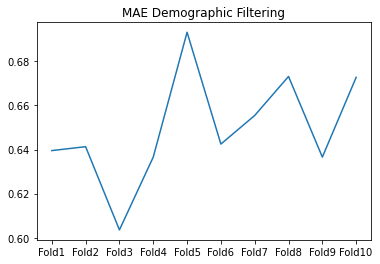

In [66]:
label_fold = ['Fold1','Fold2','Fold3','Fold4','Fold5','Fold6','Fold7','Fold8','Fold9','Fold10']
plt.plot(label_fold,mae_df)
plt.title('MAE Demographic Filtering')

Text(0.5, 1.0, 'RMSE Demographic Filtering')

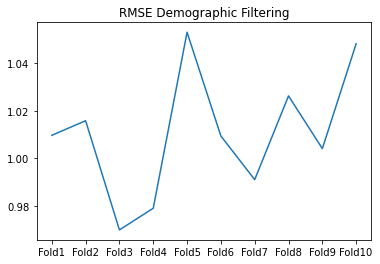

In [65]:
label_fold = ['Fold1','Fold2','Fold3','Fold4','Fold5','Fold6','Fold7','Fold8','Fold9','Fold10']
plt.plot(label_fold,rmse_df)
plt.title('RMSE Demographic Filtering')

In [115]:
plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (15, 5)

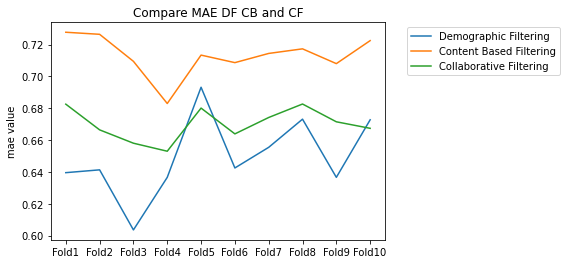

In [20]:
plt.plot(label_fold, mae_df, label='Demographic Filtering')  
plt.plot(label_fold, mae_cb, label='Content Based Filtering')
plt.plot(label_fold, mae_cf, label='Collaborative Filtering')
plt.ylabel('mae value')
plt.title("Compare MAE DF CB and CF")
plt.legend(bbox_to_anchor=(1.05, 1))

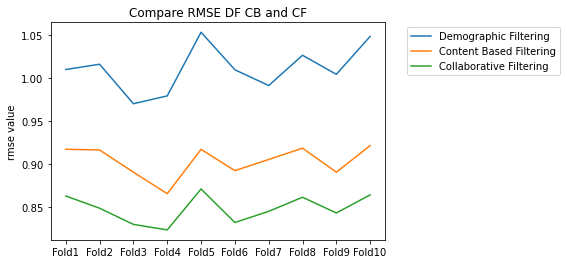

In [19]:
plt.plot(label_fold, rmse_df, label='Demographic Filtering')  
plt.plot(label_fold, rmse_cb, label='Content Based Filtering')
plt.plot(label_fold, rmse_cf, label='Collaborative Filtering')
plt.ylabel('rmse value')
plt.title("Compare RMSE DF CB and CF")
plt.legend(bbox_to_anchor=(1.05, 1))

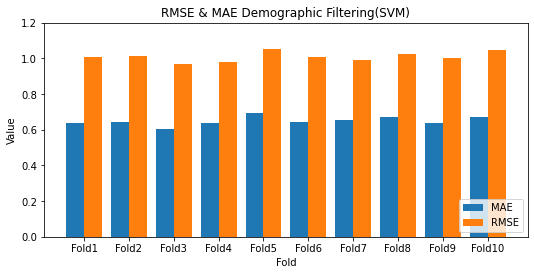

In [53]:
label_fold = ['Fold1','Fold2','Fold3','Fold4','Fold5','Fold6','Fold7','Fold8','Fold9','Fold10']
X_axis = np.arange(len(label_fold))
plt.figure(figsize=(cm_to_inch(22),cm_to_inch(10)))  
plt.bar(X_axis - 0.2, mae_df, 0.4, label = 'MAE')
plt.bar(X_axis + 0.2, rmse_df, 0.4, label = 'RMSE')
plt.xticks(X_axis, label_fold)
plt.xlabel("Fold")
plt.ylabel("Value")
plt.ylim([0, 1.2])
plt.title("RMSE & MAE Demographic Filtering(SVM)")
plt.legend(loc="lower right")
plt.show()

### Testing Model Hybrid Recommender System (Double Hybridization Switching and Weighted) with 10 Fold

In [12]:
def combine_hybrid_testing(dt_testing,dt_training,alpha,beta,gamma):
    rating_pred = []
    for index,row in dt_testing.iterrows():
        user_id = row['user_id']
        destination_id = row['destination_id']
        rating_pred.append(hybrid_combine_pred(user_id,destination_id,dt_training,alpha,beta,gamma))
    return rating_pred

In [13]:
begin_time = datetime.datetime.now()
rating_pred_combine_hybrid_fold1 = combine_hybrid_testing(dt_fold_testing1,dt_fold_training1,0.4,0.2,0.4)
rating_pred_combine_hybrid_fold2 = combine_hybrid_testing(dt_fold_testing2,dt_fold_training2,0.4,0.2,0.4)
rating_pred_combine_hybrid_fold3 = combine_hybrid_testing(dt_fold_testing3,dt_fold_training3,0.4,0.2,0.4)
rating_pred_combine_hybrid_fold4 = combine_hybrid_testing(dt_fold_testing4,dt_fold_training4,0.4,0.2,0.4)
rating_pred_combine_hybrid_fold5 = combine_hybrid_testing(dt_fold_testing5,dt_fold_training5,0.4,0.2,0.4)
print(datetime.datetime.now() - begin_time)

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_fu

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, d

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', g

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', ga

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, 

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, 

SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, 

SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, dec

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decisi

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamm

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_sh

SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
S

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, dec

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_s

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SV

SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape

SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_func

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1, 

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='s

SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=1, decision_function_sh

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma

SVC(C=0.1, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, d

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decisi

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, d

SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_sha

SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, d

SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamm

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=100, dec

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_

SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, de

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gam

SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decisi

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_fun

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='pol

SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=100, decision_function_shape='ov

SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)

SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1,

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', g

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_s

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', g

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo',

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_fun

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_

SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=

SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1

SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)

In [3]:
begin_time = datetime.datetime.now()
rating_pred_combine_hybrid_fold6 = combine_hybrid_testing(dt_fold_testing6,dt_fold_training6,0.4,0.2,0.4)
rating_pred_combine_hybrid_fold7 = combine_hybrid_testing(dt_fold_testing7,dt_fold_training7,0.4,0.2,0.4)
rating_pred_combine_hybrid_fold8 = combine_hybrid_testing(dt_fold_testing8,dt_fold_training8,0.4,0.2,0.4)
rating_pred_combine_hybrid_fold9 = combine_hybrid_testing(dt_fold_testing9,dt_fold_training9,0.4,0.2,0.4)
rating_pred_combine_hybrid_fold10 = combine_hybrid_testing(dt_fold_testing10,dt_fold_training10,0.4,0.2,0.4)
print(datetime.datetime.now() - begin_time)

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, de

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_fu

SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigm

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SV

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_functio

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo',

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1,

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo'

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, dec

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, de

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gam

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', g

SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', ga

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_functi

SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0

SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ov

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1

SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', ga

SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape

SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=100, decision_function_shape=

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C

SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel=

SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_sh

SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_fu

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kern

SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, deci

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=10, decision_function_shape='o

SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_func

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, ke

SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1,

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=100, decision_function_shape='ovo', gamma=0.1)
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_fun

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)


SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, dec

SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_functi

SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=0.1, decision_function_shap

SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decisi

SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, 

SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='sigmoid')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='poly')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid

SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=100, decision_function_shape='ovo', gamma=0.001)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=10, decision_function_shape='ovo', gamma=0.1, kernel='poly')
SVC(C=10, decision_function_shape='ovo', gamma=0.01)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1, kernel='sigmoid')
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function_shape='ovo', gamma=0.1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=0.1, decision_function_shape='ovo', gamma=1)
SVC(C=1, decision_function

### Calculate MAE and RMSE Model Hybrid Recommender System (Double Hybridization Weighted and Switching) for Each Fold 

In [4]:
mae_combine = []
rmse_combine = []
print('MAE and RMSE fold 1')
mae_combine_fold1 = find_mae(rating_pred_combine_hybrid_fold1,y_test1)
rmse_combine_fold1 = find_rmse(rating_pred_combine_hybrid_fold1,y_test1)
print(mae_combine_fold1)
print(rmse_combine_fold1)
mae_combine.append(mae_combine_fold1)
rmse_combine.append(rmse_combine_fold1)

MAE and RMSE fold 1
0.6685798346012247
0.8729449942871855


In [5]:
print('MAE and RMSE fold 2')
mae_combine_fold2 = find_mae(rating_pred_combine_hybrid_fold2,y_test2)
rmse_combine_fold2 = find_rmse(rating_pred_combine_hybrid_fold2,y_test2)
print(mae_combine_fold2)
print(rmse_combine_fold2)
mae_combine.append(mae_combine_fold2)
rmse_combine.append(rmse_combine_fold2)

MAE and RMSE fold 2
0.662729065675259
0.8652023855586835


In [6]:
print('MAE and RMSE fold 3')
mae_combine_fold3 = find_mae(rating_pred_combine_hybrid_fold3,y_test3)
rmse_combine_fold3 = find_rmse(rating_pred_combine_hybrid_fold3,y_test3)
print(mae_combine_fold3)
print(rmse_combine_fold3)
mae_combine.append(mae_combine_fold3)
rmse_combine.append(rmse_combine_fold3)

MAE and RMSE fold 3
0.6408128103934112
0.835589303112113


In [7]:
print('MAE and RMSE fold 4')
mae_combine_fold4 = find_mae(rating_pred_combine_hybrid_fold4,y_test4)
rmse_combine_fold4 = find_rmse(rating_pred_combine_hybrid_fold4,y_test4)
print(mae_combine_fold4)
print(rmse_combine_fold4)
mae_combine.append(mae_combine_fold4)
rmse_combine.append(rmse_combine_fold4)

MAE and RMSE fold 4
0.6472254909216033
0.8352404133287422


In [8]:
print('MAE and RMSE fold 5')
mae_combine_fold5 = find_mae(rating_pred_combine_hybrid_fold5,y_test5)
rmse_combine_fold5 = find_rmse(rating_pred_combine_hybrid_fold5,y_test5)
print(mae_combine_fold5)
print(rmse_combine_fold5)
mae_combine.append(mae_combine_fold5)
rmse_combine.append(rmse_combine_fold5)

MAE and RMSE fold 5
0.6901344723216164
0.8992172701164654


In [15]:
print('MAE and RMSE fold 6')
mae_combine_fold6 = find_mae(rating_pred_combine_hybrid_fold6,y_test6)
rmse_combine_fold6 = find_rmse(rating_pred_combine_hybrid_fold6,y_test6)
print(mae_combine_fold6)
print(rmse_combine_fold6)
mae_combine.append(mae_combine_fold6)
rmse_combine.append(rmse_combine_fold6)

MAE and RMSE fold 6
0.6587090278266957
0.849563831393653


In [16]:
print('MAE and RMSE fold 7')
mae_combine_fold7 = find_mae(rating_pred_combine_hybrid_fold7,y_test7)
rmse_combine_fold7 = find_rmse(rating_pred_combine_hybrid_fold7,y_test7)
print(mae_combine_fold7)
print(rmse_combine_fold7)
mae_combine.append(mae_combine_fold7)
rmse_combine.append(rmse_combine_fold7)

MAE and RMSE fold 7
0.6724254335146238
0.8610769788755499


In [17]:
print('MAE and RMSE fold 8')
mae_combine_fold8 = find_mae(rating_pred_combine_hybrid_fold8,y_test8)
rmse_combine_fold8 = find_rmse(rating_pred_combine_hybrid_fold8,y_test8)
print(mae_combine_fold8)
print(rmse_combine_fold8)
mae_combine.append(mae_combine_fold8)
rmse_combine.append(rmse_combine_fold8)

MAE and RMSE fold 8
0.6838823737844357
0.8793481152039806


In [18]:
print('MAE and RMSE fold 9')
mae_combine_fold9 = find_mae(rating_pred_combine_hybrid_fold9,y_test9)
rmse_combine_fold9 = find_rmse(rating_pred_combine_hybrid_fold9,y_test9)
print(mae_combine_fold9)
print(rmse_combine_fold9)
mae_combine.append(mae_combine_fold9)
rmse_combine.append(rmse_combine_fold9)

MAE and RMSE fold 9
0.6604015367471684
0.8547736469222533


In [19]:
print('MAE and RMSE fold 10')
mae_combine_fold10 = find_mae(rating_pred_combine_hybrid_fold10,y_test10)
rmse_combine_fold10 = find_rmse(rating_pred_combine_hybrid_fold10,y_test10)
print(mae_combine_fold10)
print(rmse_combine_fold10)
mae_combine.append(mae_combine_fold10)
rmse_combine.append(rmse_combine_fold10)

MAE and RMSE fold 10
0.6751671132275976
0.8912373163215981


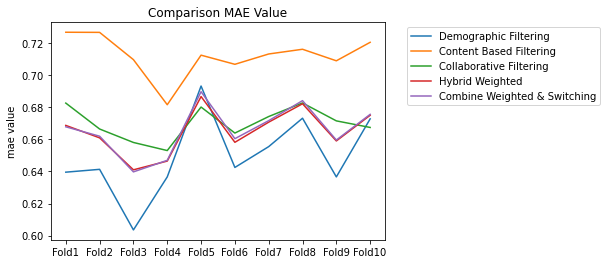

In [46]:
plt.plot(label_fold, mae_df, label='Demographic Filtering')  
plt.plot(label_fold, mae_cb, label='Content Based Filtering')
plt.plot(label_fold, mae_cf, label='Collaborative Filtering')
plt.plot(label_fold,mae_weighted,label='Hybrid Weighted')
plt.plot(label_fold,mae_combine,label='Combine Weighted & Switching')
plt.ylabel('mae value')
plt.title("Comparison MAE Value")
plt.legend(bbox_to_anchor=(1.05, 1))

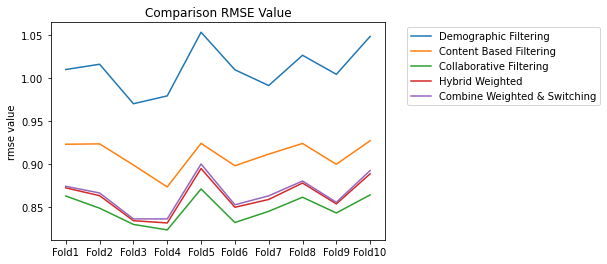

In [47]:
plt.plot(label_fold, rmse_df, label='Demographic Filtering')  
plt.plot(label_fold, rmse_cb, label='Content Based Filtering')
plt.plot(label_fold, rmse_cf, label='Collaborative Filtering')
plt.plot(label_fold,rmse_weighted,label='Hybrid Weighted')
plt.plot(label_fold,rmse_combine,label='Combine Weighted & Switching')
plt.ylabel('rmse value')
plt.title("Comparison RMSE Value")
plt.legend(bbox_to_anchor=(1.05, 1))

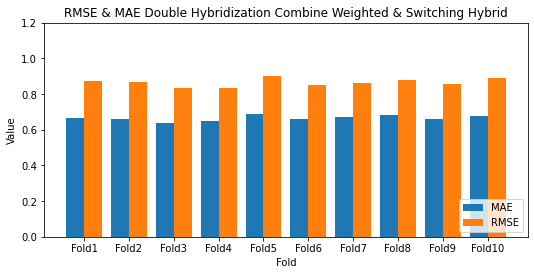

In [4]:
label_fold = ['Fold1','Fold2','Fold3','Fold4','Fold5','Fold6','Fold7','Fold8','Fold9','Fold10']
X_axis = np.arange(len(label_fold))
plt.figure(figsize=(cm_to_inch(22),cm_to_inch(10)))  
plt.bar(X_axis - 0.2, mae_combine, 0.4, label = 'MAE')
plt.bar(X_axis + 0.2, rmse_combine, 0.4, label = 'RMSE')
plt.xticks(X_axis, label_fold)
plt.xlabel("Fold")
plt.ylabel("Value")
plt.ylim([0, 1.2])
plt.title("RMSE & MAE Double Hybridization Combine Weighted & Switching Hybrid")
plt.legend(loc="lower right")
plt.show()

### Calculate Average MAE and RMSE in Every Model

In [5]:
avg_rmse_combine = sum(rmse_combine) / len(rmse_combine)
avg_mae_combine = sum(mae_combine) / len(mae_combine)
print('Average RMSE New Hybrid Method : ',avg_rmse_combine)
print('Average MAE New Hybrid Method : ',avg_mae_combine)

Average RMSE New Hybrid Method :  0.8644194255120224
Average MAE New Hybrid Method :  0.6660067159013637


In [10]:
avg_rmse_df = sum(rmse_df) / len(rmse_df)
avg_mae_df = sum(mae_df) / len(mae_df)
print('Average RMSE Demographic Method : ',avg_rmse_df)
print('Average MAE Demographic Method : ',avg_mae_df)

Average RMSE Demographic Method :  1.0106468170604725
Average MAE Demographic Method :  0.6494588342516836


In [11]:
avg_rmse_cb = sum(rmse_cb) / len(rmse_cb)
avg_mae_cb = sum(mae_cb) / len(mae_cb)
print('Average RMSE Content Based Method : ',avg_rmse_cb)
print('Average MAE Content Based Method : ',avg_mae_cb)

Average RMSE Content Based Method :  0.910444868409729
Average MAE Content Based Method :  0.7122585864509513


In [12]:
avg_rmse_cf = sum(rmse_cf) / len(rmse_cf)
avg_mae_cf = sum(mae_cf) / len(mae_cf)
print('Average RMSE Collaborative Filtering Method : ',avg_rmse_cf)
print('Average MAE Collaborative Filtering Method : ',avg_mae_cf)

Average RMSE Collaborative Filtering Method :  0.8484823378430235
Average MAE Collaborative Filtering Method :  0.6699880883801876


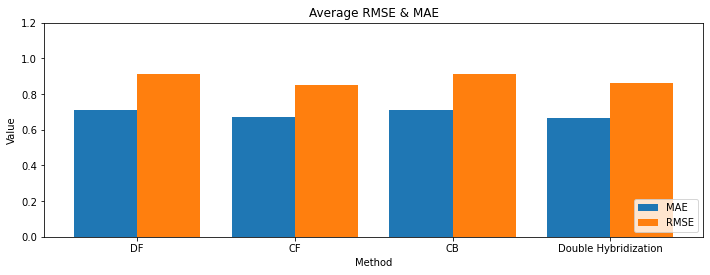

In [3]:
label_fold = ['DF','CF','CB','Double Hybridization']
data_avg_mae = [avg_mae_df,avg_mae_cf,avg_mae_cb,avg_mae_combine]
data_avg_rmse = [avg_rmse_df,avg_rmse_cf,avg_rmse_cb,avg_rmse_combine]
X_axis = np.arange(len(label_fold))
plt.figure(figsize=(cm_to_inch(30),cm_to_inch(10)))  
plt.bar(X_axis - 0.2, data_avg_mae, 0.4, label = 'MAE')
plt.bar(X_axis + 0.2, data_avg_rmse, 0.4, label = 'RMSE')
plt.xticks(X_axis, label_fold)
plt.xlabel("Method")
plt.ylabel("Value")
plt.ylim([0, 1.2])
plt.title("Average RMSE & MAE")
plt.legend(loc="lower right")
plt.show()

In [13]:
### using dill library to save the session in notebook
import dill
dill.dump_session('notebook_env.db')